##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 使用内置方法进行训练和评估

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://tensorflow.google.cn/guide/keras/train_and_evaluate"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a>   </td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/guide/keras/train_and_evaluate.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行 </a></td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/guide/keras/train_and_evaluate.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 上查看源代码</a>   </td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/guide/keras/train_and_evaluate.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a>   </td>
</table>

## 设置

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2022-12-14 21:24:55.689069: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 21:24:55.689163: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 21:24:55.689172: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## 简介

本指南涵盖使用内置 API 进行训练和验证时的训练、评估和预测（推断）模型（例如 `Model.fit()`、`Model.evaluate()` 和 `Model.predict()`）。

如果您有兴趣在指定自己的训练步骤函数时利用 `fit()`，请参阅<a data-md-type="raw_html" href="https://tensorflow.google.cn/guide/keras/customizing_what_happens_in_fit/">自定义 `fit()` 的功能</a>指南。

如果您有兴趣从头开始编写自己的训练和评估循环，请参阅[从头开始编写训练循环](https://tensorflow.google.cn/guide/keras/writing_a_training_loop_from_scratch/)指南。

一般而言，无论您使用内置循环还是编写自己的循环，模型训练和评估都会在每种 Keras 模型（序贯模型、使用函数式 API 构建的模型以及通过模型子类化从头编写的模型）中严格按照相同的方式工作。

本指南不涉及分布式训练，这部分内容会在我们的[多 GPU 和分布式训练指南](https://keras.io/guides/distributed_training/)中进行介绍。

## API 概述：第一个端到端示例

将数据传递到模型的内置训练循环时，应当使用 **NumPy 数组**（如果数据很小且适合装入内存）或 **`tf.data Dataset` 对象**。在接下来的段落中，我们将 MNIST 数据集用作 NumPy 数组，以演示如何使用优化器、损失和指标。

我们考虑以下模型（在这里，我们使用函数式 API 构建了此模型，但它也可以是序贯模型或子类化模型）：

In [3]:
inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, activation="softmax", name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

下面是典型的端到端工作流，包括：

- 训练
- 根据从原始训练数据生成的预留集进行验证
- 对测试数据进行评估

在此示例中，我们使用 MNIST 数据。

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Preprocess the data (these are NumPy arrays)
x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# Reserve 10,000 samples for validation
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

我们指定训练配置（优化器、损失、指标）：

In [5]:
model.compile(
    optimizer=keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

我们调用 `fit()`，它会通过将数据切分成大小为 `batch_size` 的“批次”，然后在给定数量的 `epochs` 内重复遍历整个数据集来训练模型。

In [6]:
print("Fit model on training data")
history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=2,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, y_val),
)

Fit model on training data
Epoch 1/2


  1/782 [..............................] - ETA: 17:15 - loss: 2.3341 - sparse_categorical_accuracy: 0.1094

 23/782 [..............................] - ETA: 1s - loss: 1.6160 - sparse_categorical_accuracy: 0.5489   

 46/782 [>.............................] - ETA: 1s - loss: 1.2412 - sparse_categorical_accuracy: 0.6658

 69/782 [=>............................] - ETA: 1s - loss: 1.0225 - sparse_categorical_accuracy: 0.7255

 92/782 [==>...........................] - ETA: 1s - loss: 0.9045 - sparse_categorical_accuracy: 0.7549

115/782 [===>..........................] - ETA: 1s - loss: 0.8077 - sparse_categorical_accuracy: 0.7808

139/782 [====>.........................] - ETA: 1s - loss: 0.7354 - sparse_categorical_accuracy: 0.7996

162/782 [=====>........................] - ETA: 1s - loss: 0.6784 - sparse_categorical_accuracy: 0.8148

186/782 [======>.......................] - ETA: 1s - loss: 0.6380 - sparse_categorical_accuracy: 0.8243

210/782 [=======>......................] - ETA: 1s - loss: 0.6041 - sparse_categorical_accuracy: 0.8324

235/782 [========>.....................] - ETA: 1s - loss: 0.5735 - sparse_categorical_accuracy: 0.8407

260/782 [========>.....................] - ETA: 1s - loss: 0.5478 - sparse_categorical_accuracy: 0.8478

284/782 [=========>....................] - ETA: 1s - loss: 0.5271 - sparse_categorical_accuracy: 0.8531

308/782 [==========>...................] - ETA: 1s - loss: 0.5107 - sparse_categorical_accuracy: 0.8575

332/782 [===========>..................] - ETA: 0s - loss: 0.4952 - sparse_categorical_accuracy: 0.8616

356/782 [============>.................] - ETA: 0s - loss: 0.4810 - sparse_categorical_accuracy: 0.8657

380/782 [=============>................] - ETA: 0s - loss: 0.4697 - sparse_categorical_accuracy: 0.8683

403/782 [==============>...............] - ETA: 0s - loss: 0.4571 - sparse_categorical_accuracy: 0.8718

426/782 [===============>..............] - ETA: 0s - loss: 0.4470 - sparse_categorical_accuracy: 0.8745

449/782 [================>.............] - ETA: 0s - loss: 0.4377 - sparse_categorical_accuracy: 0.8770

472/782 [=================>............] - ETA: 0s - loss: 0.4287 - sparse_categorical_accuracy: 0.8791

496/782 [==================>...........] - ETA: 0s - loss: 0.4193 - sparse_categorical_accuracy: 0.8817

519/782 [==================>...........] - ETA: 0s - loss: 0.4117 - sparse_categorical_accuracy: 0.8841

543/782 [===================>..........] - ETA: 0s - loss: 0.4025 - sparse_categorical_accuracy: 0.8867

566/782 [====================>.........] - ETA: 0s - loss: 0.3964 - sparse_categorical_accuracy: 0.8881

590/782 [=====================>........] - ETA: 0s - loss: 0.3889 - sparse_categorical_accuracy: 0.8905

613/782 [======================>.......] - ETA: 0s - loss: 0.3833 - sparse_categorical_accuracy: 0.8918

637/782 [=======================>......] - ETA: 0s - loss: 0.3777 - sparse_categorical_accuracy: 0.8933

661/782 [========================>.....] - ETA: 0s - loss: 0.3728 - sparse_categorical_accuracy: 0.8944

684/782 [=========================>....] - ETA: 0s - loss: 0.3674 - sparse_categorical_accuracy: 0.8957

708/782 [==========================>...] - ETA: 0s - loss: 0.3624 - sparse_categorical_accuracy: 0.8971

732/782 [===========================>..] - ETA: 0s - loss: 0.3562 - sparse_categorical_accuracy: 0.8986

755/782 [===========================>..] - ETA: 0s - loss: 0.3516 - sparse_categorical_accuracy: 0.8998

778/782 [============================>.] - ETA: 0s - loss: 0.3481 - sparse_categorical_accuracy: 0.9007

782/782 [==============================] - 3s 3ms/step - loss: 0.3473 - sparse_categorical_accuracy: 0.9009 - val_loss: 0.1936 - val_sparse_categorical_accuracy: 0.9444


Epoch 2/2


  1/782 [..............................] - ETA: 2s - loss: 0.2749 - sparse_categorical_accuracy: 0.8906

 24/782 [..............................] - ETA: 1s - loss: 0.2012 - sparse_categorical_accuracy: 0.9408

 48/782 [>.............................] - ETA: 1s - loss: 0.1834 - sparse_categorical_accuracy: 0.9463

 72/782 [=>............................] - ETA: 1s - loss: 0.1830 - sparse_categorical_accuracy: 0.9438

 96/782 [==>...........................] - ETA: 1s - loss: 0.1833 - sparse_categorical_accuracy: 0.9416

121/782 [===>..........................] - ETA: 1s - loss: 0.1786 - sparse_categorical_accuracy: 0.9454

145/782 [====>.........................] - ETA: 1s - loss: 0.1760 - sparse_categorical_accuracy: 0.9460

169/782 [=====>........................] - ETA: 1s - loss: 0.1792 - sparse_categorical_accuracy: 0.9455

193/782 [======>.......................] - ETA: 1s - loss: 0.1758 - sparse_categorical_accuracy: 0.9462

217/782 [=======>......................] - ETA: 1s - loss: 0.1743 - sparse_categorical_accuracy: 0.9474

241/782 [========>.....................] - ETA: 1s - loss: 0.1722 - sparse_categorical_accuracy: 0.9481

265/782 [=========>....................] - ETA: 1s - loss: 0.1730 - sparse_categorical_accuracy: 0.9479

288/782 [==========>...................] - ETA: 1s - loss: 0.1750 - sparse_categorical_accuracy: 0.9474

311/782 [==========>...................] - ETA: 1s - loss: 0.1743 - sparse_categorical_accuracy: 0.9477

335/782 [===========>..................] - ETA: 0s - loss: 0.1718 - sparse_categorical_accuracy: 0.9483

359/782 [============>.................] - ETA: 0s - loss: 0.1703 - sparse_categorical_accuracy: 0.9487

382/782 [=============>................] - ETA: 0s - loss: 0.1708 - sparse_categorical_accuracy: 0.9482

404/782 [==============>...............] - ETA: 0s - loss: 0.1713 - sparse_categorical_accuracy: 0.9482

427/782 [===============>..............] - ETA: 0s - loss: 0.1709 - sparse_categorical_accuracy: 0.9483

451/782 [================>.............] - ETA: 0s - loss: 0.1702 - sparse_categorical_accuracy: 0.9486

475/782 [=================>............] - ETA: 0s - loss: 0.1696 - sparse_categorical_accuracy: 0.9487

499/782 [==================>...........] - ETA: 0s - loss: 0.1689 - sparse_categorical_accuracy: 0.9488

523/782 [===================>..........] - ETA: 0s - loss: 0.1677 - sparse_categorical_accuracy: 0.9491

546/782 [===================>..........] - ETA: 0s - loss: 0.1672 - sparse_categorical_accuracy: 0.9491

570/782 [====================>.........] - ETA: 0s - loss: 0.1678 - sparse_categorical_accuracy: 0.9492

594/782 [=====================>........] - ETA: 0s - loss: 0.1672 - sparse_categorical_accuracy: 0.9493

617/782 [======================>.......] - ETA: 0s - loss: 0.1673 - sparse_categorical_accuracy: 0.9493

641/782 [=======================>......] - ETA: 0s - loss: 0.1675 - sparse_categorical_accuracy: 0.9492

665/782 [========================>.....] - ETA: 0s - loss: 0.1657 - sparse_categorical_accuracy: 0.9496

689/782 [=========================>....] - ETA: 0s - loss: 0.1647 - sparse_categorical_accuracy: 0.9500

713/782 [==========================>...] - ETA: 0s - loss: 0.1636 - sparse_categorical_accuracy: 0.9502

736/782 [===========================>..] - ETA: 0s - loss: 0.1629 - sparse_categorical_accuracy: 0.9504

759/782 [============================>.] - ETA: 0s - loss: 0.1619 - sparse_categorical_accuracy: 0.9507

782/782 [==============================] - ETA: 0s - loss: 0.1616 - sparse_categorical_accuracy: 0.9507

782/782 [==============================] - 2s 2ms/step - loss: 0.1616 - sparse_categorical_accuracy: 0.9507 - val_loss: 0.1324 - val_sparse_categorical_accuracy: 0.9605


返回的 `history` 对象保存训练期间的损失值和指标值记录：

In [7]:
history.history

{'loss': [0.3473339378833771, 0.16158732771873474],
 'sparse_categorical_accuracy': [0.9008600115776062, 0.9506999850273132],
 'val_loss': [0.19355881214141846, 0.13244354724884033],
 'val_sparse_categorical_accuracy': [0.9444000124931335, 0.9605000019073486]}

我们通过 `evaluate()` 在测试数据上评估模型：

In [8]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(x_test[:3])
print("predictions shape:", predictions.shape)

Evaluate on test data
 1/79 [..............................] - ETA: 1s - loss: 0.0433 - sparse_categorical_accuracy: 1.0000

28/79 [=========>....................] - ETA: 0s - loss: 0.1775 - sparse_categorical_accuracy: 0.9461

55/79 [===================>..........] - ETA: 0s - loss: 0.1599 - sparse_categorical_accuracy: 0.9537

79/79 [==============================] - 0s 2ms/step - loss: 0.1384 - sparse_categorical_accuracy: 0.9599


test loss, test acc: [0.13839252293109894, 0.9599000215530396]
Generate predictions for 3 samples


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 71ms/step


predictions shape: (3, 10)


现在，我们来详细查看此工作流的每一部分。

## `compile()` 方法：指定损失、指标和优化器

要使用 `fit()` 训练模型，您需要指定损失函数、优化器以及一些要监视的指标（可选）。

将它们作为 `compile()` 方法的参数传递给模型：

In [9]:
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

`metrics` 参数应当为列表 - 您的模型可以具有任意数量的指标。

如果您的模型具有多个输出，则可以为每个输出指定不同的损失和指标，并且可以调整每个输出对模型总损失的贡献。您可以在**将数据传递到多输入、多输出模型**部分中找到有关此问题的更多详细信息。

请注意，如果您对默认设置感到满意，那么在许多情况下，都可以通过字符串标识符将优化器、损失和指标指定为捷径：

In [10]:
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

为方便以后重用，我们将模型定义和编译步骤放入函数中；我们将在本指南的不同示例中多次调用它们。

In [11]:
def get_uncompiled_model():
    inputs = keras.Input(shape=(784,), name="digits")
    x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
    x = layers.Dense(64, activation="relu", name="dense_2")(x)
    outputs = layers.Dense(10, activation="softmax", name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_compiled_model():
    model = get_uncompiled_model()
    model.compile(
        optimizer="rmsprop",
        loss="sparse_categorical_crossentropy",
        metrics=["sparse_categorical_accuracy"],
    )
    return model


### 提供许多内置优化器、损失和指标

通常，您不必从头开始创建自己的损失、指标或优化器，因为您需要的可能已经是 Keras API 的一部分：

优化器：

- `SGD()`（有或没有动量）
- `RMSprop()`
- `Adam()`
- 等等

损失：

- `MeanSquaredError()`
- `KLDivergence()`
- `CosineSimilarity()`
- 等等

指标：

- `AUC()`
- `Precision()`
- `Recall()`
- 等等

### 自定义损失

如果您需要创建自定义损失，Keras 提供了两种方式。

第一种方式涉及创建一个接受输入 `y_true` 和 `y_pred` 的函数。下面的示例显示了一个计算实际数据与预测值之间均方误差的损失函数：

In [12]:
def custom_mean_squared_error(y_true, y_pred):
    return tf.math.reduce_mean(tf.square(y_true - y_pred))


model = get_uncompiled_model()
model.compile(optimizer=keras.optimizers.Adam(), loss=custom_mean_squared_error)

# We need to one-hot encode the labels to use MSE
y_train_one_hot = tf.one_hot(y_train, depth=10)
model.fit(x_train, y_train_one_hot, batch_size=64, epochs=1)

  1/782 [..............................] - ETA: 14:08 - loss: 0.0911

 25/782 [..............................] - ETA: 1s - loss: 0.0786   

 50/782 [>.............................] - ETA: 1s - loss: 0.0611

 75/782 [=>............................] - ETA: 1s - loss: 0.0505

 99/782 [==>...........................] - ETA: 1s - loss: 0.0434

124/782 [===>..........................] - ETA: 1s - loss: 0.0387

149/782 [====>.........................] - ETA: 1s - loss: 0.0353

174/782 [=====>........................] - ETA: 1s - loss: 0.0326

199/782 [======>.......................] - ETA: 1s - loss: 0.0303

223/782 [=======>......................] - ETA: 1s - loss: 0.0285

248/782 [========>.....................] - ETA: 1s - loss: 0.0270

273/782 [=========>....................] - ETA: 1s - loss: 0.0258

298/782 [==========>...................] - ETA: 0s - loss: 0.0248

323/782 [===========>..................] - ETA: 0s - loss: 0.0239

348/782 [============>.................] - ETA: 0s - loss: 0.0231

372/782 [=============>................] - ETA: 0s - loss: 0.0223

396/782 [==============>...............] - ETA: 0s - loss: 0.0217

420/782 [===============>..............] - ETA: 0s - loss: 0.0211

444/782 [================>.............] - ETA: 0s - loss: 0.0206

469/782 [================>.............] - ETA: 0s - loss: 0.0201

495/782 [=================>............] - ETA: 0s - loss: 0.0196

520/782 [==================>...........] - ETA: 0s - loss: 0.0192

544/782 [===================>..........] - ETA: 0s - loss: 0.0188

569/782 [====================>.........] - ETA: 0s - loss: 0.0184

594/782 [=====================>........] - ETA: 0s - loss: 0.0181

619/782 [======================>.......] - ETA: 0s - loss: 0.0178

644/782 [=======================>......] - ETA: 0s - loss: 0.0175

668/782 [========================>.....] - ETA: 0s - loss: 0.0172

693/782 [=========================>....] - ETA: 0s - loss: 0.0169

718/782 [==========================>...] - ETA: 0s - loss: 0.0166

743/782 [===========================>..] - ETA: 0s - loss: 0.0164

768/782 [============================>.] - ETA: 0s - loss: 0.0161

782/782 [==============================] - 3s 2ms/step - loss: 0.0160


如果您需要一个使用除 `y_true` 和 `y_pred` 之外的其他参数的损失函数，则可以将 `tf.keras.losses.Loss` 类子类化，并实现以下两种方法：

- `__init__(self)`：接受要在调用损失函数期间传递的参数
- `call(self, y_true, y_pred)`：使用目标 (y_true) 和模型预测 (y_pred) 来计算模型的损失

假设您要使用均方误差，但存在一个会抑制预测值远离 0.5（我们假设分类目标采用独热编码，且取值介于 0 和 1 之间）的附加项。这会为模型创建一个激励，使其不会对预测值过于自信，这可能有助于减轻过拟合（在尝试之前，我们不知道它是否有效！）。

您可以按以下方式处理：

In [13]:
class CustomMSE(keras.losses.Loss):
    def __init__(self, regularization_factor=0.1, name="custom_mse"):
        super().__init__(name=name)
        self.regularization_factor = regularization_factor

    def call(self, y_true, y_pred):
        mse = tf.math.reduce_mean(tf.square(y_true - y_pred))
        reg = tf.math.reduce_mean(tf.square(0.5 - y_pred))
        return mse + reg * self.regularization_factor


model = get_uncompiled_model()
model.compile(optimizer=keras.optimizers.Adam(), loss=CustomMSE())

y_train_one_hot = tf.one_hot(y_train, depth=10)
model.fit(x_train, y_train_one_hot, batch_size=64, epochs=1)

  1/782 [..............................] - ETA: 12:16 - loss: 0.1067

 23/782 [..............................] - ETA: 1s - loss: 0.0934   

 46/782 [>.............................] - ETA: 1s - loss: 0.0777

 69/782 [=>............................] - ETA: 1s - loss: 0.0678

 92/782 [==>...........................] - ETA: 1s - loss: 0.0615

115/782 [===>..........................] - ETA: 1s - loss: 0.0577

138/782 [====>.........................] - ETA: 1s - loss: 0.0548

161/782 [=====>........................] - ETA: 1s - loss: 0.0525

184/782 [======>.......................] - ETA: 1s - loss: 0.0507

207/782 [======>.......................] - ETA: 1s - loss: 0.0493

231/782 [=======>......................] - ETA: 1s - loss: 0.0480

255/782 [========>.....................] - ETA: 1s - loss: 0.0471

278/782 [=========>....................] - ETA: 1s - loss: 0.0463

301/782 [==========>...................] - ETA: 1s - loss: 0.0456

324/782 [===========>..................] - ETA: 1s - loss: 0.0450

347/782 [============>.................] - ETA: 0s - loss: 0.0445

370/782 [=============>................] - ETA: 0s - loss: 0.0439

394/782 [==============>...............] - ETA: 0s - loss: 0.0433

417/782 [==============>...............] - ETA: 0s - loss: 0.0429

440/782 [===============>..............] - ETA: 0s - loss: 0.0424

463/782 [================>.............] - ETA: 0s - loss: 0.0420

487/782 [=================>............] - ETA: 0s - loss: 0.0417

510/782 [==================>...........] - ETA: 0s - loss: 0.0414

532/782 [===================>..........] - ETA: 0s - loss: 0.0411

554/782 [====================>.........] - ETA: 0s - loss: 0.0409

577/782 [=====================>........] - ETA: 0s - loss: 0.0406

600/782 [======================>.......] - ETA: 0s - loss: 0.0404

623/782 [======================>.......] - ETA: 0s - loss: 0.0401

646/782 [=======================>......] - ETA: 0s - loss: 0.0399

669/782 [========================>.....] - ETA: 0s - loss: 0.0396

692/782 [=========================>....] - ETA: 0s - loss: 0.0394

715/782 [==========================>...] - ETA: 0s - loss: 0.0392

738/782 [===========================>..] - ETA: 0s - loss: 0.0389

761/782 [============================>.] - ETA: 0s - loss: 0.0387

782/782 [==============================] - 3s 2ms/step - loss: 0.0386


### 自定义指标

如果您需要一个不属于 API 一部分的指标，则可以通过将 `tf.keras.metrics.Metric` 类子类化来轻松创建自定义指标。您需要实现 4 种方法：

- `__init__(self)`，您将在其中为您的指标创建状态变量。
- `update_state(self, y_true, y_pred, sample_weight=None)`，它使用目标 y_true 和模型预测 y_pred 来更新状态变量。
- `result(self)`，它使用状态变量来计算最终结果。
- `reset_state(self)`，它重新初始化指标的状态。

状态更新和结果计算是分开进行的（分别在 `update_state()` 和 `result()` 中），因为在某些情况下，结果计算的开销可能非常巨大并且只能定期进行。

下面以一个简单的示例展示了如何实现一个计算有多少样本被正确分类为属于给定类的 `CategoricalTruePositives` 指标：

In [14]:
class CategoricalTruePositives(keras.metrics.Metric):
    def __init__(self, name="categorical_true_positives", **kwargs):
        super(CategoricalTruePositives, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name="ctp", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.reshape(tf.argmax(y_pred, axis=1), shape=(-1, 1))
        values = tf.cast(y_true, "int32") == tf.cast(y_pred, "int32")
        values = tf.cast(values, "float32")
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, "float32")
            values = tf.multiply(values, sample_weight)
        self.true_positives.assign_add(tf.reduce_sum(values))

    def result(self):
        return self.true_positives

    def reset_state(self):
        # The state of the metric will be reset at the start of each epoch.
        self.true_positives.assign(0.0)


model = get_uncompiled_model()
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[CategoricalTruePositives()],
)
model.fit(x_train, y_train, batch_size=64, epochs=3)

Epoch 1/3


  1/782 [..............................] - ETA: 9:34 - loss: 2.2613 - categorical_true_positives: 11.0000

 25/782 [..............................] - ETA: 1s - loss: 1.5528 - categorical_true_positives: 959.0000 

 49/782 [>.............................] - ETA: 1s - loss: 1.1701 - categorical_true_positives: 2234.0000

 73/782 [=>............................] - ETA: 1s - loss: 0.9652 - categorical_true_positives: 3545.0000

 97/782 [==>...........................] - ETA: 1s - loss: 0.8409 - categorical_true_positives: 4895.0000

121/782 [===>..........................] - ETA: 1s - loss: 0.7536 - categorical_true_positives: 6253.0000

144/782 [====>.........................] - ETA: 1s - loss: 0.6888 - categorical_true_positives: 7581.0000

168/782 [=====>........................] - ETA: 1s - loss: 0.6431 - categorical_true_positives: 8957.0000

192/782 [======>.......................] - ETA: 1s - loss: 0.6140 - categorical_true_positives: 10321.0000

215/782 [=======>......................] - ETA: 1s - loss: 0.5870 - categorical_true_positives: 11638.0000

238/782 [========>.....................] - ETA: 1s - loss: 0.5632 - categorical_true_positives: 12960.0000

262/782 [=========>....................] - ETA: 1s - loss: 0.5399 - categorical_true_positives: 14357.0000

286/782 [=========>....................] - ETA: 1s - loss: 0.5203 - categorical_true_positives: 15748.0000

310/782 [==========>...................] - ETA: 1s - loss: 0.5018 - categorical_true_positives: 17154.0000

334/782 [===========>..................] - ETA: 0s - loss: 0.4871 - categorical_true_positives: 18553.0000

359/782 [============>.................] - ETA: 0s - loss: 0.4731 - categorical_true_positives: 20025.0000

384/782 [=============>................] - ETA: 0s - loss: 0.4602 - categorical_true_positives: 21498.0000

408/782 [==============>...............] - ETA: 0s - loss: 0.4501 - categorical_true_positives: 22900.0000

432/782 [===============>..............] - ETA: 0s - loss: 0.4398 - categorical_true_positives: 24319.0000

456/782 [================>.............] - ETA: 0s - loss: 0.4322 - categorical_true_positives: 25723.0000

481/782 [=================>............] - ETA: 0s - loss: 0.4228 - categorical_true_positives: 27202.0000

506/782 [==================>...........] - ETA: 0s - loss: 0.4131 - categorical_true_positives: 28695.0000

530/782 [===================>..........] - ETA: 0s - loss: 0.4053 - categorical_true_positives: 30122.0000

554/782 [====================>.........] - ETA: 0s - loss: 0.3989 - categorical_true_positives: 31549.0000

578/782 [=====================>........] - ETA: 0s - loss: 0.3924 - categorical_true_positives: 32969.0000

602/782 [======================>.......] - ETA: 0s - loss: 0.3851 - categorical_true_positives: 34403.0000

626/782 [=======================>......] - ETA: 0s - loss: 0.3797 - categorical_true_positives: 35823.0000

650/782 [=======================>......] - ETA: 0s - loss: 0.3737 - categorical_true_positives: 37271.0000

674/782 [========================>.....] - ETA: 0s - loss: 0.3678 - categorical_true_positives: 38701.0000

698/782 [=========================>....] - ETA: 0s - loss: 0.3630 - categorical_true_positives: 40133.0000

722/782 [==========================>...] - ETA: 0s - loss: 0.3585 - categorical_true_positives: 41549.0000

746/782 [===========================>..] - ETA: 0s - loss: 0.3537 - categorical_true_positives: 42994.0000

770/782 [============================>.] - ETA: 0s - loss: 0.3492 - categorical_true_positives: 44441.0000

782/782 [==============================] - 2s 2ms/step - loss: 0.3474 - categorical_true_positives: 45106.0000


Epoch 2/3


  1/782 [..............................] - ETA: 2s - loss: 0.2403 - categorical_true_positives: 60.0000

 24/782 [..............................] - ETA: 1s - loss: 0.1939 - categorical_true_positives: 1447.0000

 47/782 [>.............................] - ETA: 1s - loss: 0.1968 - categorical_true_positives: 2829.0000

 72/782 [=>............................] - ETA: 1s - loss: 0.1933 - categorical_true_positives: 4339.0000

 96/782 [==>...........................] - ETA: 1s - loss: 0.1998 - categorical_true_positives: 5772.0000

119/782 [===>..........................] - ETA: 1s - loss: 0.1960 - categorical_true_positives: 7175.0000

143/782 [====>.........................] - ETA: 1s - loss: 0.1927 - categorical_true_positives: 8634.0000

167/782 [=====>........................] - ETA: 1s - loss: 0.1898 - categorical_true_positives: 10094.0000

191/782 [======>.......................] - ETA: 1s - loss: 0.1904 - categorical_true_positives: 11547.0000

214/782 [=======>......................] - ETA: 1s - loss: 0.1890 - categorical_true_positives: 12950.0000

236/782 [========>.....................] - ETA: 1s - loss: 0.1878 - categorical_true_positives: 14290.0000

259/782 [========>.....................] - ETA: 1s - loss: 0.1892 - categorical_true_positives: 15664.0000

282/782 [=========>....................] - ETA: 1s - loss: 0.1861 - categorical_true_positives: 17079.0000

305/782 [==========>...................] - ETA: 1s - loss: 0.1872 - categorical_true_positives: 18467.0000

328/782 [===========>..................] - ETA: 0s - loss: 0.1857 - categorical_true_positives: 19854.0000

351/782 [============>.................] - ETA: 0s - loss: 0.1846 - categorical_true_positives: 21256.0000

374/782 [=============>................] - ETA: 0s - loss: 0.1834 - categorical_true_positives: 22651.0000

397/782 [==============>...............] - ETA: 0s - loss: 0.1823 - categorical_true_positives: 24043.0000

420/782 [===============>..............] - ETA: 0s - loss: 0.1795 - categorical_true_positives: 25462.0000

442/782 [===============>..............] - ETA: 0s - loss: 0.1786 - categorical_true_positives: 26797.0000

464/782 [================>.............] - ETA: 0s - loss: 0.1783 - categorical_true_positives: 28137.0000

487/782 [=================>............] - ETA: 0s - loss: 0.1772 - categorical_true_positives: 29538.0000

510/782 [==================>...........] - ETA: 0s - loss: 0.1769 - categorical_true_positives: 30935.0000

533/782 [===================>..........] - ETA: 0s - loss: 0.1764 - categorical_true_positives: 32337.0000

556/782 [====================>.........] - ETA: 0s - loss: 0.1756 - categorical_true_positives: 33742.0000

579/782 [=====================>........] - ETA: 0s - loss: 0.1749 - categorical_true_positives: 35147.0000

602/782 [======================>.......] - ETA: 0s - loss: 0.1732 - categorical_true_positives: 36567.0000

625/782 [======================>.......] - ETA: 0s - loss: 0.1712 - categorical_true_positives: 37983.0000

648/782 [=======================>......] - ETA: 0s - loss: 0.1709 - categorical_true_positives: 39383.0000

672/782 [========================>.....] - ETA: 0s - loss: 0.1702 - categorical_true_positives: 40848.0000

695/782 [=========================>....] - ETA: 0s - loss: 0.1698 - categorical_true_positives: 42259.0000

719/782 [==========================>...] - ETA: 0s - loss: 0.1697 - categorical_true_positives: 43719.0000

742/782 [===========================>..] - ETA: 0s - loss: 0.1689 - categorical_true_positives: 45122.0000

766/782 [============================>.] - ETA: 0s - loss: 0.1681 - categorical_true_positives: 46584.0000

782/782 [==============================] - 2s 2ms/step - loss: 0.1668 - categorical_true_positives: 47531.0000


Epoch 3/3


  1/782 [..............................] - ETA: 2s - loss: 0.1184 - categorical_true_positives: 61.0000

 25/782 [..............................] - ETA: 1s - loss: 0.1467 - categorical_true_positives: 1529.0000

 49/782 [>.............................] - ETA: 1s - loss: 0.1507 - categorical_true_positives: 2999.0000

 73/782 [=>............................] - ETA: 1s - loss: 0.1354 - categorical_true_positives: 4481.0000

 98/782 [==>...........................] - ETA: 1s - loss: 0.1288 - categorical_true_positives: 6026.0000

122/782 [===>..........................] - ETA: 1s - loss: 0.1262 - categorical_true_positives: 7504.0000

146/782 [====>.........................] - ETA: 1s - loss: 0.1232 - categorical_true_positives: 8982.0000

170/782 [=====>........................] - ETA: 1s - loss: 0.1236 - categorical_true_positives: 10464.0000

194/782 [======>.......................] - ETA: 1s - loss: 0.1233 - categorical_true_positives: 11956.0000

218/782 [=======>......................] - ETA: 1s - loss: 0.1237 - categorical_true_positives: 13431.0000

242/782 [========>.....................] - ETA: 1s - loss: 0.1233 - categorical_true_positives: 14913.0000

266/782 [=========>....................] - ETA: 1s - loss: 0.1256 - categorical_true_positives: 16380.0000

289/782 [==========>...................] - ETA: 1s - loss: 0.1279 - categorical_true_positives: 17784.0000

313/782 [===========>..................] - ETA: 0s - loss: 0.1271 - categorical_true_positives: 19274.0000

337/782 [===========>..................] - ETA: 0s - loss: 0.1266 - categorical_true_positives: 20746.0000

360/782 [============>.................] - ETA: 0s - loss: 0.1256 - categorical_true_positives: 22172.0000

384/782 [=============>................] - ETA: 0s - loss: 0.1262 - categorical_true_positives: 23648.0000

407/782 [==============>...............] - ETA: 0s - loss: 0.1272 - categorical_true_positives: 25050.0000

431/782 [===============>..............] - ETA: 0s - loss: 0.1267 - categorical_true_positives: 26531.0000

455/782 [================>.............] - ETA: 0s - loss: 0.1261 - categorical_true_positives: 28014.0000

479/782 [=================>............] - ETA: 0s - loss: 0.1263 - categorical_true_positives: 29500.0000

503/782 [==================>...........] - ETA: 0s - loss: 0.1255 - categorical_true_positives: 30995.0000

527/782 [===================>..........] - ETA: 0s - loss: 0.1243 - categorical_true_positives: 32488.0000

551/782 [====================>.........] - ETA: 0s - loss: 0.1233 - categorical_true_positives: 33976.0000

575/782 [=====================>........] - ETA: 0s - loss: 0.1237 - categorical_true_positives: 35448.0000

599/782 [=====================>........] - ETA: 0s - loss: 0.1235 - categorical_true_positives: 36936.0000

623/782 [======================>.......] - ETA: 0s - loss: 0.1236 - categorical_true_positives: 38417.0000

647/782 [=======================>......] - ETA: 0s - loss: 0.1235 - categorical_true_positives: 39894.0000

672/782 [========================>.....] - ETA: 0s - loss: 0.1230 - categorical_true_positives: 41440.0000

697/782 [=========================>....] - ETA: 0s - loss: 0.1237 - categorical_true_positives: 42983.0000

721/782 [==========================>...] - ETA: 0s - loss: 0.1227 - categorical_true_positives: 44471.0000

745/782 [===========================>..] - ETA: 0s - loss: 0.1227 - categorical_true_positives: 45959.0000

769/782 [============================>.] - ETA: 0s - loss: 0.1225 - categorical_true_positives: 47445.0000

782/782 [==============================] - 2s 2ms/step - loss: 0.1219 - categorical_true_positives: 48207.0000


### 处理不适合标准签名的损失和指标

绝大多数损失和指标都可以通过 `y_true` 和 `y_pred` 计算得出，其中 `y_pred` 是模型的输出，但不是全部。例如，正则化损失可能仅需要激活层（在这种情况下没有目标），并且这种激活可能不是模型输出。

在此类情况下，您可以从自定义层的调用方法内部调用 `self.add_loss(loss_value)`。以这种方式添加的损失会在训练期间添加到“主要”损失中（传递给 `compile()` 的损失）。下面是一个添加激活正则化的简单示例（请注意，激活正则化内置于所有 Keras 层中 - 此层只是为了提供一个具体示例）：

In [15]:
class ActivityRegularizationLayer(layers.Layer):
    def call(self, inputs):
        self.add_loss(tf.reduce_sum(inputs) * 0.1)
        return inputs  # Pass-through layer.


inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)

# Insert activity regularization as a layer
x = ActivityRegularizationLayer()(x)

x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)

# The displayed loss will be much higher than before
# due to the regularization component.
model.fit(x_train, y_train, batch_size=64, epochs=1)

  1/782 [..............................] - ETA: 8:39 - loss: 90.2398

 27/782 [>.............................] - ETA: 1s - loss: 8.9180   

 54/782 [=>............................] - ETA: 1s - loss: 5.6710

 81/782 [==>...........................] - ETA: 1s - loss: 4.5567

107/782 [===>..........................] - ETA: 1s - loss: 4.0126

134/782 [====>.........................] - ETA: 1s - loss: 3.6690

161/782 [=====>........................] - ETA: 1s - loss: 3.4400

187/782 [======>.......................] - ETA: 1s - loss: 3.2825

214/782 [=======>......................] - ETA: 1s - loss: 3.1587

241/782 [========>.....................] - ETA: 1s - loss: 3.0629

267/782 [=========>....................] - ETA: 0s - loss: 2.9891

294/782 [==========>...................] - ETA: 0s - loss: 2.9261

321/782 [===========>..................] - ETA: 0s - loss: 2.8739

348/782 [============>.................] - ETA: 0s - loss: 2.8296

374/782 [=============>................] - ETA: 0s - loss: 2.7929

400/782 [==============>...............] - ETA: 0s - loss: 2.7609

426/782 [===============>..............] - ETA: 0s - loss: 2.7329

451/782 [================>.............] - ETA: 0s - loss: 2.7091

476/782 [=================>............] - ETA: 0s - loss: 2.6877

501/782 [==================>...........] - ETA: 0s - loss: 2.6684

526/782 [===================>..........] - ETA: 0s - loss: 2.6511

551/782 [====================>.........] - ETA: 0s - loss: 2.6351

576/782 [=====================>........] - ETA: 0s - loss: 2.6207

602/782 [======================>.......] - ETA: 0s - loss: 2.6070

629/782 [=======================>......] - ETA: 0s - loss: 2.5938

655/782 [========================>.....] - ETA: 0s - loss: 2.5822

680/782 [=========================>....] - ETA: 0s - loss: 2.5718

707/782 [==========================>...] - ETA: 0s - loss: 2.5615

734/782 [===========================>..] - ETA: 0s - loss: 2.5520

762/782 [============================>.] - ETA: 0s - loss: 2.5427

782/782 [==============================] - 2s 2ms/step - loss: 2.5368


您可以使用 `add_metric()` 对记录指标值执行相同的操作：

In [16]:
class MetricLoggingLayer(layers.Layer):
    def call(self, inputs):
        # The `aggregation` argument defines
        # how to aggregate the per-batch values
        # over each epoch:
        # in this case we simply average them.
        self.add_metric(
            keras.backend.std(inputs), name="std_of_activation", aggregation="mean"
        )
        return inputs  # Pass-through layer.


inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)

# Insert std logging as a layer.
x = MetricLoggingLayer()(x)

x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)
model.fit(x_train, y_train, batch_size=64, epochs=1)

  1/782 [..............................] - ETA: 8:57 - loss: 2.3995 - std_of_activation: 0.2849

 24/782 [..............................] - ETA: 1s - loss: 1.5487 - std_of_activation: 0.4526  

 49/782 [>.............................] - ETA: 1s - loss: 1.1695 - std_of_activation: 0.5794

 75/782 [=>............................] - ETA: 1s - loss: 0.9418 - std_of_activation: 0.6624

100/782 [==>...........................] - ETA: 1s - loss: 0.8155 - std_of_activation: 0.7200

124/782 [===>..........................] - ETA: 1s - loss: 0.7453 - std_of_activation: 0.7601

148/782 [====>.........................] - ETA: 1s - loss: 0.6889 - std_of_activation: 0.7911

173/782 [=====>........................] - ETA: 1s - loss: 0.6416 - std_of_activation: 0.8158

195/782 [======>.......................] - ETA: 1s - loss: 0.6055 - std_of_activation: 0.8337

219/782 [=======>......................] - ETA: 1s - loss: 0.5756 - std_of_activation: 0.8516

243/782 [========>.....................] - ETA: 1s - loss: 0.5497 - std_of_activation: 0.8669

267/782 [=========>....................] - ETA: 1s - loss: 0.5284 - std_of_activation: 0.8789

291/782 [==========>...................] - ETA: 1s - loss: 0.5090 - std_of_activation: 0.8902

315/782 [===========>..................] - ETA: 0s - loss: 0.4929 - std_of_activation: 0.8986

339/782 [============>.................] - ETA: 0s - loss: 0.4803 - std_of_activation: 0.9063

363/782 [============>.................] - ETA: 0s - loss: 0.4686 - std_of_activation: 0.9136

387/782 [=============>................] - ETA: 0s - loss: 0.4558 - std_of_activation: 0.9190

411/782 [==============>...............] - ETA: 0s - loss: 0.4443 - std_of_activation: 0.9251

435/782 [===============>..............] - ETA: 0s - loss: 0.4345 - std_of_activation: 0.9296

459/782 [================>.............] - ETA: 0s - loss: 0.4242 - std_of_activation: 0.9338

483/782 [=================>............] - ETA: 0s - loss: 0.4157 - std_of_activation: 0.9387

507/782 [==================>...........] - ETA: 0s - loss: 0.4071 - std_of_activation: 0.9429

532/782 [===================>..........] - ETA: 0s - loss: 0.3998 - std_of_activation: 0.9471

556/782 [====================>.........] - ETA: 0s - loss: 0.3915 - std_of_activation: 0.9506

581/782 [=====================>........] - ETA: 0s - loss: 0.3844 - std_of_activation: 0.9542

606/782 [======================>.......] - ETA: 0s - loss: 0.3774 - std_of_activation: 0.9577

630/782 [=======================>......] - ETA: 0s - loss: 0.3718 - std_of_activation: 0.9608

654/782 [========================>.....] - ETA: 0s - loss: 0.3659 - std_of_activation: 0.9636

677/782 [========================>.....] - ETA: 0s - loss: 0.3619 - std_of_activation: 0.9666

701/782 [=========================>....] - ETA: 0s - loss: 0.3564 - std_of_activation: 0.9694

725/782 [==========================>...] - ETA: 0s - loss: 0.3515 - std_of_activation: 0.9718

749/782 [===========================>..] - ETA: 0s - loss: 0.3478 - std_of_activation: 0.9734

774/782 [============================>.] - ETA: 0s - loss: 0.3436 - std_of_activation: 0.9754

782/782 [==============================] - 2s 2ms/step - loss: 0.3427 - std_of_activation: 0.9762


在[函数式 API](https://tensorflow.google.cn/guide/keras/functional/) 中，您还可以调用 `model.add_loss(loss_tensor)` 或 `model.add_metric(metric_tensor, name, aggregation)`。

下面是一个简单的示例：

In [17]:
inputs = keras.Input(shape=(784,), name="digits")
x1 = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x2 = layers.Dense(64, activation="relu", name="dense_2")(x1)
outputs = layers.Dense(10, name="predictions")(x2)
model = keras.Model(inputs=inputs, outputs=outputs)

model.add_loss(tf.reduce_sum(x1) * 0.1)

model.add_metric(keras.backend.std(x1), name="std_of_activation", aggregation="mean")

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)
model.fit(x_train, y_train, batch_size=64, epochs=1)

  1/782 [..............................] - ETA: 9:19 - loss: 93.3453 - std_of_activation: 0.2837

 24/782 [..............................] - ETA: 1s - loss: 10.2339 - std_of_activation: 0.0513  

 48/782 [>.............................] - ETA: 1s - loss: 6.3552 - std_of_activation: 0.0295 

 71/782 [=>............................] - ETA: 1s - loss: 5.0520 - std_of_activation: 0.0208

 94/782 [==>...........................] - ETA: 1s - loss: 4.3841 - std_of_activation: 0.0162

117/782 [===>..........................] - ETA: 1s - loss: 3.9769 - std_of_activation: 0.0132

140/782 [====>.........................] - ETA: 1s - loss: 3.7028 - std_of_activation: 0.0112

163/782 [=====>........................] - ETA: 1s - loss: 3.5053 - std_of_activation: 0.0096

187/782 [======>.......................] - ETA: 1s - loss: 3.3512 - std_of_activation: 0.0085

212/782 [=======>......................] - ETA: 1s - loss: 3.2276 - std_of_activation: 0.0075

237/782 [========>.....................] - ETA: 1s - loss: 3.1302 - std_of_activation: 0.0067

262/782 [=========>....................] - ETA: 1s - loss: 3.0513 - std_of_activation: 0.0061

287/782 [==========>...................] - ETA: 1s - loss: 2.9860 - std_of_activation: 0.0056

311/782 [==========>...................] - ETA: 1s - loss: 2.9333 - std_of_activation: 0.0052

336/782 [===========>..................] - ETA: 0s - loss: 2.8863 - std_of_activation: 0.0048

361/782 [============>.................] - ETA: 0s - loss: 2.8459 - std_of_activation: 0.0045

385/782 [=============>................] - ETA: 0s - loss: 2.8121 - std_of_activation: 0.0042

410/782 [==============>...............] - ETA: 0s - loss: 2.7811 - std_of_activation: 0.0040

435/782 [===============>..............] - ETA: 0s - loss: 2.7535 - std_of_activation: 0.0038

460/782 [================>.............] - ETA: 0s - loss: 2.7289 - std_of_activation: 0.0036

485/782 [=================>............] - ETA: 0s - loss: 2.7069 - std_of_activation: 0.0034

510/782 [==================>...........] - ETA: 0s - loss: 2.6871 - std_of_activation: 0.0032

534/782 [===================>..........] - ETA: 0s - loss: 2.6698 - std_of_activation: 0.0031

559/782 [====================>.........] - ETA: 0s - loss: 2.6534 - std_of_activation: 0.0029

584/782 [=====================>........] - ETA: 0s - loss: 2.6385 - std_of_activation: 0.0028

609/782 [======================>.......] - ETA: 0s - loss: 2.6246 - std_of_activation: 0.0027

634/782 [=======================>......] - ETA: 0s - loss: 2.6118 - std_of_activation: 0.0026

658/782 [========================>.....] - ETA: 0s - loss: 2.6005 - std_of_activation: 0.0025

683/782 [=========================>....] - ETA: 0s - loss: 2.5895 - std_of_activation: 0.0024

708/782 [==========================>...] - ETA: 0s - loss: 2.5794 - std_of_activation: 0.0023

733/782 [===========================>..] - ETA: 0s - loss: 2.5700 - std_of_activation: 0.0023

758/782 [============================>.] - ETA: 0s - loss: 2.5612 - std_of_activation: 0.0022

782/782 [==============================] - ETA: 0s - loss: 2.5534 - std_of_activation: 0.0021

782/782 [==============================] - 2s 2ms/step - loss: 2.5534 - std_of_activation: 0.0021


请注意，当您通过 `add_loss()` 传递损失时，可以在没有损失函数的情况下调用 `compile()`，因为模型已经有损失要最小化。

考虑以下 `LogisticEndpoint` 层：它以目标和 logits 作为输入，并通过 `add_loss()` 跟踪交叉熵损失。另外，它还通过 `add_metric()` 跟踪分类准确率。

In [18]:
class LogisticEndpoint(keras.layers.Layer):
    def __init__(self, name=None):
        super(LogisticEndpoint, self).__init__(name=name)
        self.loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
        self.accuracy_fn = keras.metrics.BinaryAccuracy()

    def call(self, targets, logits, sample_weights=None):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        loss = self.loss_fn(targets, logits, sample_weights)
        self.add_loss(loss)

        # Log accuracy as a metric and add it
        # to the layer using `self.add_metric()`.
        acc = self.accuracy_fn(targets, logits, sample_weights)
        self.add_metric(acc, name="accuracy")

        # Return the inference-time prediction tensor (for `.predict()`).
        return tf.nn.softmax(logits)


您可以在具有两个输入（输入数据和目标）的模型中使用它，编译时无需 `loss` 参数，如下所示：

In [19]:
import numpy as np

inputs = keras.Input(shape=(3,), name="inputs")
targets = keras.Input(shape=(10,), name="targets")
logits = keras.layers.Dense(10)(inputs)
predictions = LogisticEndpoint(name="predictions")(logits, targets)

model = keras.Model(inputs=[inputs, targets], outputs=predictions)
model.compile(optimizer="adam")  # No loss argument!

data = {
    "inputs": np.random.random((3, 3)),
    "targets": np.random.random((3, 10)),
}
model.fit(data)

1/1 [==============================] - ETA: 0s - loss: 1.0727 - binary_accuracy: 0.0000e+00

1/1 [==============================] - 1s 503ms/step - loss: 1.0727 - binary_accuracy: 0.0000e+00


有关训练多输入模型的更多信息，请参阅**将数据传递到多输入、多输出模型**部分。

### 自动分离验证预留集

在您看到的第一个端到端示例中，我们使用了 `validation_data` 参数将 NumPy 数组 `(x_val, y_val)` 的元组传递给模型，用于在每个周期结束时评估验证损失和验证指标。

这是另一个选项：参数 `validation_split` 允许您自动保留部分训练数据以供验证。参数值表示要保留用于验证的数据比例，因此应将其设置为大于 0 且小于 1 的数字。例如，`validation_split=0.2` 表示“使用 20% 的数据进行验证”，而 `validation_split=0.6` 表示“使用 60% 的数据进行验证”。

验证的计算方法是在进行任何打乱顺序之前，获取 `fit()` 调用接收到的数组的最后 x% 个样本。

请注意，仅在使用 NumPy 数据进行训练时才能使用 `validation_split`。

In [20]:
model = get_compiled_model()
model.fit(x_train, y_train, batch_size=64, validation_split=0.2, epochs=1)

  1/625 [..............................] - ETA: 7:03 - loss: 2.2898 - sparse_categorical_accuracy: 0.1562

 25/625 [>.............................] - ETA: 1s - loss: 1.5192 - sparse_categorical_accuracy: 0.5775  

 51/625 [=>............................] - ETA: 1s - loss: 1.1340 - sparse_categorical_accuracy: 0.6915

 76/625 [==>...........................] - ETA: 1s - loss: 0.9445 - sparse_categorical_accuracy: 0.7424

102/625 [===>..........................] - ETA: 1s - loss: 0.8234 - sparse_categorical_accuracy: 0.7736

129/625 [=====>........................] - ETA: 0s - loss: 0.7322 - sparse_categorical_accuracy: 0.7977

156/625 [======>.......................] - ETA: 0s - loss: 0.6726 - sparse_categorical_accuracy: 0.8135

183/625 [=======>......................] - ETA: 0s - loss: 0.6242 - sparse_categorical_accuracy: 0.8268

209/625 [=========>....................] - ETA: 0s - loss: 0.5902 - sparse_categorical_accuracy: 0.8364

234/625 [==========>...................] - ETA: 0s - loss: 0.5630 - sparse_categorical_accuracy: 0.8426

260/625 [===========>..................] - ETA: 0s - loss: 0.5379 - sparse_categorical_accuracy: 0.8498

287/625 [============>.................] - ETA: 0s - loss: 0.5173 - sparse_categorical_accuracy: 0.8554

311/625 [=============>................] - ETA: 0s - loss: 0.5005 - sparse_categorical_accuracy: 0.8600

336/625 [===============>..............] - ETA: 0s - loss: 0.4836 - sparse_categorical_accuracy: 0.8637

362/625 [================>.............] - ETA: 0s - loss: 0.4684 - sparse_categorical_accuracy: 0.8677

387/625 [=================>............] - ETA: 0s - loss: 0.4546 - sparse_categorical_accuracy: 0.8711

412/625 [==================>...........] - ETA: 0s - loss: 0.4417 - sparse_categorical_accuracy: 0.8745

437/625 [===================>..........] - ETA: 0s - loss: 0.4285 - sparse_categorical_accuracy: 0.8785

463/625 [=====================>........] - ETA: 0s - loss: 0.4193 - sparse_categorical_accuracy: 0.8812

489/625 [======================>.......] - ETA: 0s - loss: 0.4081 - sparse_categorical_accuracy: 0.8841

515/625 [=======================>......] - ETA: 0s - loss: 0.4009 - sparse_categorical_accuracy: 0.8859

541/625 [========================>.....] - ETA: 0s - loss: 0.3925 - sparse_categorical_accuracy: 0.8882

567/625 [==========================>...] - ETA: 0s - loss: 0.3862 - sparse_categorical_accuracy: 0.8900

592/625 [===========================>..] - ETA: 0s - loss: 0.3793 - sparse_categorical_accuracy: 0.8921

618/625 [============================>.] - ETA: 0s - loss: 0.3732 - sparse_categorical_accuracy: 0.8939

625/625 [==============================] - 2s 3ms/step - loss: 0.3719 - sparse_categorical_accuracy: 0.8944 - val_loss: 0.2294 - val_sparse_categorical_accuracy: 0.9302


## 通过 tf.data 数据集进行训练和评估

在上面的几个段落中，您已经了解了如何处理损失、指标和优化器，并且已经了解当数据作为 NumPy 数组传递时，如何在 `fit()` 中使用 `validation_data` 和 `validation_split` 参数。

现在，让我们看一下数据以 `tf.data.Dataset` 对象形式出现的情况。

`tf.data` API 是 TensorFlow 2.0 中的一组实用工具，用于以快速且可扩展的方式加载和预处理数据。

有关创建 `Datasets` 的完整指南，请参阅 [tf.data 文档](https://tensorflow.google.cn/guide/data)。

您可以将 `Dataset` 实例直接传递给方法 `fit()`、`evaluate()` 和 `predict()`：

In [21]:
model = get_compiled_model()

# First, let's create a training Dataset instance.
# For the sake of our example, we'll use the same MNIST data as before.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# Shuffle and slice the dataset.
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Now we get a test dataset.
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(64)

# Since the dataset already takes care of batching,
# we don't pass a `batch_size` argument.
model.fit(train_dataset, epochs=3)

# You can also evaluate or predict on a dataset.
print("Evaluate")
result = model.evaluate(test_dataset)
dict(zip(model.metrics_names, result))

Epoch 1/3


  1/782 [..............................] - ETA: 8:57 - loss: 2.3237 - sparse_categorical_accuracy: 0.1719

 26/782 [..............................] - ETA: 1s - loss: 1.5353 - sparse_categorical_accuracy: 0.5679  

 50/782 [>.............................] - ETA: 1s - loss: 1.1461 - sparse_categorical_accuracy: 0.6931

 74/782 [=>............................] - ETA: 1s - loss: 0.9393 - sparse_categorical_accuracy: 0.7523

 98/782 [==>...........................] - ETA: 1s - loss: 0.8017 - sparse_categorical_accuracy: 0.7897

122/782 [===>..........................] - ETA: 1s - loss: 0.7295 - sparse_categorical_accuracy: 0.8074

146/782 [====>.........................] - ETA: 1s - loss: 0.6790 - sparse_categorical_accuracy: 0.8193

171/782 [=====>........................] - ETA: 1s - loss: 0.6269 - sparse_categorical_accuracy: 0.8318

196/782 [======>.......................] - ETA: 1s - loss: 0.5905 - sparse_categorical_accuracy: 0.8414

221/782 [=======>......................] - ETA: 1s - loss: 0.5645 - sparse_categorical_accuracy: 0.8476

246/782 [========>.....................] - ETA: 1s - loss: 0.5423 - sparse_categorical_accuracy: 0.8525

270/782 [=========>....................] - ETA: 1s - loss: 0.5233 - sparse_categorical_accuracy: 0.8574

295/782 [==========>...................] - ETA: 1s - loss: 0.5033 - sparse_categorical_accuracy: 0.8628

320/782 [===========>..................] - ETA: 0s - loss: 0.4851 - sparse_categorical_accuracy: 0.8681

345/782 [============>.................] - ETA: 0s - loss: 0.4690 - sparse_categorical_accuracy: 0.8723

370/782 [=============>................] - ETA: 0s - loss: 0.4548 - sparse_categorical_accuracy: 0.8760

395/782 [==============>...............] - ETA: 0s - loss: 0.4415 - sparse_categorical_accuracy: 0.8795

420/782 [===============>..............] - ETA: 0s - loss: 0.4317 - sparse_categorical_accuracy: 0.8823

445/782 [================>.............] - ETA: 0s - loss: 0.4211 - sparse_categorical_accuracy: 0.8850

469/782 [================>.............] - ETA: 0s - loss: 0.4125 - sparse_categorical_accuracy: 0.8868

494/782 [=================>............] - ETA: 0s - loss: 0.4053 - sparse_categorical_accuracy: 0.8886

518/782 [==================>...........] - ETA: 0s - loss: 0.3977 - sparse_categorical_accuracy: 0.8905

543/782 [===================>..........] - ETA: 0s - loss: 0.3895 - sparse_categorical_accuracy: 0.8926

568/782 [====================>.........] - ETA: 0s - loss: 0.3814 - sparse_categorical_accuracy: 0.8947

590/782 [=====================>........] - ETA: 0s - loss: 0.3771 - sparse_categorical_accuracy: 0.8957

613/782 [======================>.......] - ETA: 0s - loss: 0.3716 - sparse_categorical_accuracy: 0.8973

638/782 [=======================>......] - ETA: 0s - loss: 0.3653 - sparse_categorical_accuracy: 0.8990

663/782 [========================>.....] - ETA: 0s - loss: 0.3593 - sparse_categorical_accuracy: 0.9008

688/782 [=========================>....] - ETA: 0s - loss: 0.3545 - sparse_categorical_accuracy: 0.9018

714/782 [==========================>...] - ETA: 0s - loss: 0.3497 - sparse_categorical_accuracy: 0.9030

739/782 [===========================>..] - ETA: 0s - loss: 0.3450 - sparse_categorical_accuracy: 0.9043

763/782 [============================>.] - ETA: 0s - loss: 0.3405 - sparse_categorical_accuracy: 0.9051

782/782 [==============================] - 2s 2ms/step - loss: 0.3383 - sparse_categorical_accuracy: 0.9057


Epoch 2/3


  1/782 [..............................] - ETA: 3s - loss: 0.1231 - sparse_categorical_accuracy: 0.9844

 25/782 [..............................] - ETA: 1s - loss: 0.1991 - sparse_categorical_accuracy: 0.9456

 49/782 [>.............................] - ETA: 1s - loss: 0.1772 - sparse_categorical_accuracy: 0.9499

 72/782 [=>............................] - ETA: 1s - loss: 0.1794 - sparse_categorical_accuracy: 0.9503

 96/782 [==>...........................] - ETA: 1s - loss: 0.1750 - sparse_categorical_accuracy: 0.9513

120/782 [===>..........................] - ETA: 1s - loss: 0.1739 - sparse_categorical_accuracy: 0.9507

144/782 [====>.........................] - ETA: 1s - loss: 0.1816 - sparse_categorical_accuracy: 0.9481

168/782 [=====>........................] - ETA: 1s - loss: 0.1787 - sparse_categorical_accuracy: 0.9492

192/782 [======>.......................] - ETA: 1s - loss: 0.1786 - sparse_categorical_accuracy: 0.9486

217/782 [=======>......................] - ETA: 1s - loss: 0.1755 - sparse_categorical_accuracy: 0.9497

241/782 [========>.....................] - ETA: 1s - loss: 0.1772 - sparse_categorical_accuracy: 0.9488

266/782 [=========>....................] - ETA: 1s - loss: 0.1773 - sparse_categorical_accuracy: 0.9491

291/782 [==========>...................] - ETA: 1s - loss: 0.1745 - sparse_categorical_accuracy: 0.9502

315/782 [===========>..................] - ETA: 0s - loss: 0.1709 - sparse_categorical_accuracy: 0.9512

339/782 [============>.................] - ETA: 0s - loss: 0.1719 - sparse_categorical_accuracy: 0.9509

363/782 [============>.................] - ETA: 0s - loss: 0.1713 - sparse_categorical_accuracy: 0.9509

387/782 [=============>................] - ETA: 0s - loss: 0.1700 - sparse_categorical_accuracy: 0.9512

412/782 [==============>...............] - ETA: 0s - loss: 0.1677 - sparse_categorical_accuracy: 0.9516

436/782 [===============>..............] - ETA: 0s - loss: 0.1680 - sparse_categorical_accuracy: 0.9515

461/782 [================>.............] - ETA: 0s - loss: 0.1682 - sparse_categorical_accuracy: 0.9513

486/782 [=================>............] - ETA: 0s - loss: 0.1669 - sparse_categorical_accuracy: 0.9515

510/782 [==================>...........] - ETA: 0s - loss: 0.1665 - sparse_categorical_accuracy: 0.9518

533/782 [===================>..........] - ETA: 0s - loss: 0.1650 - sparse_categorical_accuracy: 0.9522

557/782 [====================>.........] - ETA: 0s - loss: 0.1633 - sparse_categorical_accuracy: 0.9527

582/782 [=====================>........] - ETA: 0s - loss: 0.1633 - sparse_categorical_accuracy: 0.9527

607/782 [======================>.......] - ETA: 0s - loss: 0.1617 - sparse_categorical_accuracy: 0.9532

632/782 [=======================>......] - ETA: 0s - loss: 0.1613 - sparse_categorical_accuracy: 0.9532

656/782 [========================>.....] - ETA: 0s - loss: 0.1614 - sparse_categorical_accuracy: 0.9532

681/782 [=========================>....] - ETA: 0s - loss: 0.1608 - sparse_categorical_accuracy: 0.9533

706/782 [==========================>...] - ETA: 0s - loss: 0.1603 - sparse_categorical_accuracy: 0.9533

730/782 [===========================>..] - ETA: 0s - loss: 0.1598 - sparse_categorical_accuracy: 0.9533

755/782 [===========================>..] - ETA: 0s - loss: 0.1596 - sparse_categorical_accuracy: 0.9532

779/782 [============================>.] - ETA: 0s - loss: 0.1602 - sparse_categorical_accuracy: 0.9531

782/782 [==============================] - 2s 2ms/step - loss: 0.1603 - sparse_categorical_accuracy: 0.9531


Epoch 3/3


  1/782 [..............................] - ETA: 3s - loss: 0.1324 - sparse_categorical_accuracy: 0.9844

 25/782 [..............................] - ETA: 1s - loss: 0.1609 - sparse_categorical_accuracy: 0.9556

 50/782 [>.............................] - ETA: 1s - loss: 0.1286 - sparse_categorical_accuracy: 0.9628

 75/782 [=>............................] - ETA: 1s - loss: 0.1208 - sparse_categorical_accuracy: 0.9654

100/782 [==>...........................] - ETA: 1s - loss: 0.1196 - sparse_categorical_accuracy: 0.9647

126/782 [===>..........................] - ETA: 1s - loss: 0.1250 - sparse_categorical_accuracy: 0.9635

151/782 [====>.........................] - ETA: 1s - loss: 0.1294 - sparse_categorical_accuracy: 0.9626

176/782 [=====>........................] - ETA: 1s - loss: 0.1254 - sparse_categorical_accuracy: 0.9634

201/782 [======>.......................] - ETA: 1s - loss: 0.1254 - sparse_categorical_accuracy: 0.9630

226/782 [=======>......................] - ETA: 1s - loss: 0.1251 - sparse_categorical_accuracy: 0.9630

251/782 [========>.....................] - ETA: 1s - loss: 0.1246 - sparse_categorical_accuracy: 0.9635

276/782 [=========>....................] - ETA: 1s - loss: 0.1242 - sparse_categorical_accuracy: 0.9633

300/782 [==========>...................] - ETA: 0s - loss: 0.1215 - sparse_categorical_accuracy: 0.9641

324/782 [===========>..................] - ETA: 0s - loss: 0.1212 - sparse_categorical_accuracy: 0.9639

348/782 [============>.................] - ETA: 0s - loss: 0.1218 - sparse_categorical_accuracy: 0.9638

372/782 [=============>................] - ETA: 0s - loss: 0.1221 - sparse_categorical_accuracy: 0.9635

396/782 [==============>...............] - ETA: 0s - loss: 0.1219 - sparse_categorical_accuracy: 0.9635

420/782 [===============>..............] - ETA: 0s - loss: 0.1212 - sparse_categorical_accuracy: 0.9639

444/782 [================>.............] - ETA: 0s - loss: 0.1208 - sparse_categorical_accuracy: 0.9642

468/782 [================>.............] - ETA: 0s - loss: 0.1193 - sparse_categorical_accuracy: 0.9645

492/782 [=================>............] - ETA: 0s - loss: 0.1194 - sparse_categorical_accuracy: 0.9645

516/782 [==================>...........] - ETA: 0s - loss: 0.1193 - sparse_categorical_accuracy: 0.9646

540/782 [===================>..........] - ETA: 0s - loss: 0.1193 - sparse_categorical_accuracy: 0.9648

564/782 [====================>.........] - ETA: 0s - loss: 0.1189 - sparse_categorical_accuracy: 0.9650

588/782 [=====================>........] - ETA: 0s - loss: 0.1186 - sparse_categorical_accuracy: 0.9650

611/782 [======================>.......] - ETA: 0s - loss: 0.1176 - sparse_categorical_accuracy: 0.9652

635/782 [=======================>......] - ETA: 0s - loss: 0.1180 - sparse_categorical_accuracy: 0.9650

660/782 [========================>.....] - ETA: 0s - loss: 0.1180 - sparse_categorical_accuracy: 0.9649

685/782 [=========================>....] - ETA: 0s - loss: 0.1177 - sparse_categorical_accuracy: 0.9651

710/782 [==========================>...] - ETA: 0s - loss: 0.1173 - sparse_categorical_accuracy: 0.9653

735/782 [===========================>..] - ETA: 0s - loss: 0.1174 - sparse_categorical_accuracy: 0.9651

760/782 [============================>.] - ETA: 0s - loss: 0.1173 - sparse_categorical_accuracy: 0.9649

782/782 [==============================] - 2s 2ms/step - loss: 0.1182 - sparse_categorical_accuracy: 0.9647


Evaluate


  1/157 [..............................] - ETA: 21s - loss: 0.0772 - sparse_categorical_accuracy: 0.9844

 30/157 [====>.........................] - ETA: 0s - loss: 0.1598 - sparse_categorical_accuracy: 0.9516 

 60/157 [==========>...................] - ETA: 0s - loss: 0.1588 - sparse_categorical_accuracy: 0.9508

 89/157 [================>.............] - ETA: 0s - loss: 0.1544 - sparse_categorical_accuracy: 0.9533

119/157 [=====================>........] - ETA: 0s - loss: 0.1378 - sparse_categorical_accuracy: 0.9589

148/157 [===========================>..] - ETA: 0s - loss: 0.1205 - sparse_categorical_accuracy: 0.9638

157/157 [==============================] - 0s 2ms/step - loss: 0.1235 - sparse_categorical_accuracy: 0.9632


{'loss': 0.12354936450719833,
 'sparse_categorical_accuracy': 0.9631999731063843}

请注意，数据集会在每个周期结束时重置，因此可以在下一个周期重复使用。

如果您只想在来自此数据集的特定数量批次上进行训练，则可以传递 `steps_per_epoch` 参数，此参数可以指定在继续下一个周期之前，模型应使用此数据集运行多少训练步骤。

如果执行此操作，则不会在每个周期结束时重置数据集，而是会继续绘制接下来的批次。数据集最终将用尽数据（除非它是无限循环的数据集）。

In [22]:
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Only use the 100 batches per epoch (that's 64 * 100 samples)
model.fit(train_dataset, epochs=3, steps_per_epoch=100)

Epoch 1/3


  1/100 [..............................] - ETA: 1:07 - loss: 2.2974 - sparse_categorical_accuracy: 0.1562

 26/100 [======>.......................] - ETA: 0s - loss: 1.4623 - sparse_categorical_accuracy: 0.6178  

 51/100 [==============>...............] - ETA: 0s - loss: 1.0974 - sparse_categorical_accuracy: 0.7224

 76/100 [=====================>........] - ETA: 0s - loss: 0.8994 - sparse_categorical_accuracy: 0.7689

100/100 [==============================] - 1s 2ms/step - loss: 0.7834 - sparse_categorical_accuracy: 0.7972


Epoch 2/3


  1/100 [..............................] - ETA: 0s - loss: 0.4071 - sparse_categorical_accuracy: 0.8594

 26/100 [======>.......................] - ETA: 0s - loss: 0.4260 - sparse_categorical_accuracy: 0.8816

 51/100 [==============>...............] - ETA: 0s - loss: 0.4017 - sparse_categorical_accuracy: 0.8879

 76/100 [=====================>........] - ETA: 0s - loss: 0.3699 - sparse_categorical_accuracy: 0.8933

100/100 [==============================] - 0s 2ms/step - loss: 0.3705 - sparse_categorical_accuracy: 0.8938


Epoch 3/3


  1/100 [..............................] - ETA: 0s - loss: 0.3583 - sparse_categorical_accuracy: 0.8906

 27/100 [=======>......................] - ETA: 0s - loss: 0.3447 - sparse_categorical_accuracy: 0.9016

 53/100 [==============>...............] - ETA: 0s - loss: 0.3343 - sparse_categorical_accuracy: 0.9027

 79/100 [======================>.......] - ETA: 0s - loss: 0.3268 - sparse_categorical_accuracy: 0.9033

100/100 [==============================] - 0s 2ms/step - loss: 0.3153 - sparse_categorical_accuracy: 0.9078


### 使用验证数据集

您可以在 `fit()` 中将 `Dataset` 实例作为 `validation_data` 参数传递：

In [23]:
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(train_dataset, epochs=1, validation_data=val_dataset)

  1/782 [..............................] - ETA: 8:50 - loss: 2.3903 - sparse_categorical_accuracy: 0.0469

 24/782 [..............................] - ETA: 1s - loss: 1.5436 - sparse_categorical_accuracy: 0.6081  

 49/782 [>.............................] - ETA: 1s - loss: 1.1259 - sparse_categorical_accuracy: 0.7184

 74/782 [=>............................] - ETA: 1s - loss: 0.9280 - sparse_categorical_accuracy: 0.7644

 99/782 [==>...........................] - ETA: 1s - loss: 0.7941 - sparse_categorical_accuracy: 0.7966

125/782 [===>..........................] - ETA: 1s - loss: 0.7124 - sparse_categorical_accuracy: 0.8158

149/782 [====>.........................] - ETA: 1s - loss: 0.6638 - sparse_categorical_accuracy: 0.8258

174/782 [=====>........................] - ETA: 1s - loss: 0.6175 - sparse_categorical_accuracy: 0.8370

199/782 [======>.......................] - ETA: 1s - loss: 0.5841 - sparse_categorical_accuracy: 0.8447

224/782 [=======>......................] - ETA: 1s - loss: 0.5599 - sparse_categorical_accuracy: 0.8501

249/782 [========>.....................] - ETA: 1s - loss: 0.5406 - sparse_categorical_accuracy: 0.8533

274/782 [=========>....................] - ETA: 1s - loss: 0.5176 - sparse_categorical_accuracy: 0.8595

300/782 [==========>...................] - ETA: 0s - loss: 0.4978 - sparse_categorical_accuracy: 0.8645

325/782 [===========>..................] - ETA: 0s - loss: 0.4808 - sparse_categorical_accuracy: 0.8690

350/782 [============>.................] - ETA: 0s - loss: 0.4661 - sparse_categorical_accuracy: 0.8731

374/782 [=============>................] - ETA: 0s - loss: 0.4528 - sparse_categorical_accuracy: 0.8764

399/782 [==============>...............] - ETA: 0s - loss: 0.4393 - sparse_categorical_accuracy: 0.8796

424/782 [===============>..............] - ETA: 0s - loss: 0.4290 - sparse_categorical_accuracy: 0.8823

449/782 [================>.............] - ETA: 0s - loss: 0.4191 - sparse_categorical_accuracy: 0.8847

473/782 [=================>............] - ETA: 0s - loss: 0.4117 - sparse_categorical_accuracy: 0.8864

498/782 [==================>...........] - ETA: 0s - loss: 0.4046 - sparse_categorical_accuracy: 0.8876

523/782 [===================>..........] - ETA: 0s - loss: 0.3969 - sparse_categorical_accuracy: 0.8896

548/782 [====================>.........] - ETA: 0s - loss: 0.3893 - sparse_categorical_accuracy: 0.8914

573/782 [====================>.........] - ETA: 0s - loss: 0.3817 - sparse_categorical_accuracy: 0.8931

598/782 [=====================>........] - ETA: 0s - loss: 0.3752 - sparse_categorical_accuracy: 0.8948

624/782 [======================>.......] - ETA: 0s - loss: 0.3689 - sparse_categorical_accuracy: 0.8966

649/782 [=======================>......] - ETA: 0s - loss: 0.3641 - sparse_categorical_accuracy: 0.8977

673/782 [========================>.....] - ETA: 0s - loss: 0.3599 - sparse_categorical_accuracy: 0.8988

697/782 [=========================>....] - ETA: 0s - loss: 0.3547 - sparse_categorical_accuracy: 0.9003

720/782 [==========================>...] - ETA: 0s - loss: 0.3498 - sparse_categorical_accuracy: 0.9015

743/782 [===========================>..] - ETA: 0s - loss: 0.3463 - sparse_categorical_accuracy: 0.9022

768/782 [============================>.] - ETA: 0s - loss: 0.3417 - sparse_categorical_accuracy: 0.9034

782/782 [==============================] - 3s 3ms/step - loss: 0.3400 - sparse_categorical_accuracy: 0.9040 - val_loss: 0.1871 - val_sparse_categorical_accuracy: 0.9460


在每个周期结束时，模型将迭代验证数据集并计算验证损失和验证指标。

如果只想对此数据集中的特定数量批次运行验证，则可以传递 `validation_steps` 参数，此参数可以指定在中断验证并进入下一个周期之前，模型应使用验证数据集运行多少个验证步骤：

In [24]:
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(
    train_dataset,
    epochs=1,
    # Only run validation using the first 10 batches of the dataset
    # using the `validation_steps` argument
    validation_data=val_dataset,
    validation_steps=10,
)

  1/782 [..............................] - ETA: 8:52 - loss: 2.3679 - sparse_categorical_accuracy: 0.1250

 24/782 [..............................] - ETA: 1s - loss: 1.4862 - sparse_categorical_accuracy: 0.5990  

 47/782 [>.............................] - ETA: 1s - loss: 1.0961 - sparse_categorical_accuracy: 0.7168

 70/782 [=>............................] - ETA: 1s - loss: 0.8954 - sparse_categorical_accuracy: 0.7708

 93/782 [==>...........................] - ETA: 1s - loss: 0.7770 - sparse_categorical_accuracy: 0.8016

116/782 [===>..........................] - ETA: 1s - loss: 0.7067 - sparse_categorical_accuracy: 0.8164

139/782 [====>.........................] - ETA: 1s - loss: 0.6613 - sparse_categorical_accuracy: 0.8276

163/782 [=====>........................] - ETA: 1s - loss: 0.6159 - sparse_categorical_accuracy: 0.8387

186/782 [======>.......................] - ETA: 1s - loss: 0.5798 - sparse_categorical_accuracy: 0.8464

210/782 [=======>......................] - ETA: 1s - loss: 0.5582 - sparse_categorical_accuracy: 0.8507

234/782 [=======>......................] - ETA: 1s - loss: 0.5392 - sparse_categorical_accuracy: 0.8552

258/782 [========>.....................] - ETA: 1s - loss: 0.5186 - sparse_categorical_accuracy: 0.8609

282/782 [=========>....................] - ETA: 1s - loss: 0.5009 - sparse_categorical_accuracy: 0.8653

305/782 [==========>...................] - ETA: 1s - loss: 0.4826 - sparse_categorical_accuracy: 0.8700

329/782 [===========>..................] - ETA: 0s - loss: 0.4675 - sparse_categorical_accuracy: 0.8741

352/782 [============>.................] - ETA: 0s - loss: 0.4544 - sparse_categorical_accuracy: 0.8771

376/782 [=============>................] - ETA: 0s - loss: 0.4409 - sparse_categorical_accuracy: 0.8805

400/782 [==============>...............] - ETA: 0s - loss: 0.4293 - sparse_categorical_accuracy: 0.8837

424/782 [===============>..............] - ETA: 0s - loss: 0.4210 - sparse_categorical_accuracy: 0.8858

448/782 [================>.............] - ETA: 0s - loss: 0.4118 - sparse_categorical_accuracy: 0.8880

472/782 [=================>............] - ETA: 0s - loss: 0.4038 - sparse_categorical_accuracy: 0.8897

496/782 [==================>...........] - ETA: 0s - loss: 0.3982 - sparse_categorical_accuracy: 0.8913

519/782 [==================>...........] - ETA: 0s - loss: 0.3919 - sparse_categorical_accuracy: 0.8931

543/782 [===================>..........] - ETA: 0s - loss: 0.3847 - sparse_categorical_accuracy: 0.8947

567/782 [====================>.........] - ETA: 0s - loss: 0.3770 - sparse_categorical_accuracy: 0.8969

591/782 [=====================>........] - ETA: 0s - loss: 0.3719 - sparse_categorical_accuracy: 0.8979

615/782 [======================>.......] - ETA: 0s - loss: 0.3660 - sparse_categorical_accuracy: 0.8993

639/782 [=======================>......] - ETA: 0s - loss: 0.3606 - sparse_categorical_accuracy: 0.9006

663/782 [========================>.....] - ETA: 0s - loss: 0.3556 - sparse_categorical_accuracy: 0.9019

687/782 [=========================>....] - ETA: 0s - loss: 0.3514 - sparse_categorical_accuracy: 0.9027

711/782 [==========================>...] - ETA: 0s - loss: 0.3464 - sparse_categorical_accuracy: 0.9041

735/782 [===========================>..] - ETA: 0s - loss: 0.3429 - sparse_categorical_accuracy: 0.9050

760/782 [============================>.] - ETA: 0s - loss: 0.3381 - sparse_categorical_accuracy: 0.9062

782/782 [==============================] - 3s 2ms/step - loss: 0.3356 - sparse_categorical_accuracy: 0.9067 - val_loss: 0.3411 - val_sparse_categorical_accuracy: 0.9156


请注意，验证数据集将在每次使用后重置（这样您就可以在不同周期中始终根据相同的样本进行评估）。

通过 `Dataset` 对象进行训练时，不支持参数 `validation_split`（从训练数据生成预留集），因为此功能需要为数据集样本编制索引的能力，而 `Dataset` API 通常无法做到这一点。

## 支持的其他输入格式

除 NumPy 数组、Eager 张量和 TensorFlow `Datasets` 外，还可以使用 Pandas 数据帧或通过产生批量数据和标签的 Python 生成器训练 Keras 模型。

特别是，`keras.utils.Sequence` 类提供了一个简单的接口来构建可感知多处理并且可以打乱顺序的 Python 数据生成器。

通常，我们建议您使用：

- NumPy 输入数据，前提是您的数据很小且适合装入内存
- `Dataset` 对象，前提是您有大型数据集，且需要执行分布式训练
- `Sequence` 对象，前提是您具有大型数据集，且需要执行很多无法在 TensorFlow 中完成的自定义 Python 端处理（例如，如果您依赖外部库进行数据加载或预处理）。

## 使用 `keras.utils.Sequence` 对象作为输入

`keras.utils.Sequence` 是一个实用工具，您可以将其子类化以获得具有两个重要属性的 Python 生成器：

- 它适用于多处理。
- 可以打乱它的顺序（例如，在 `fit()` 中传递 `shuffle=True` 时）。

`Sequence` 必须实现两个方法：

- `__getitem__`
- `__len__`

`__getitem__` 方法应返回完整的批次。如果要在各个周期之间修改数据集，可以实现 `on_epoch_end`。

下面是一个简单的示例：

```python
from skimage.io import imread
from skimage.transform import resize
import numpy as np

# Here, `filenames` is list of path to the images
# and `labels` are the associated labels.

class CIFAR10Sequence(Sequence):
    def __init__(self, filenames, labels, batch_size):
        self.filenames, self.labels = filenames, labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        return np.array([
            resize(imread(filename), (200, 200))
               for filename in batch_x]), np.array(batch_y)

sequence = CIFAR10Sequence(filenames, labels, batch_size)
model.fit(sequence, epochs=10)
```

## 使用样本加权和类加权

在默认设置下，样本的权重由其在数据集中出现的频率决定。您可以通过两种方式独立于样本频率来加权数据：

- 类权重
- 样本权重

### 类权重

通过将字典传递给 `Model.fit()` 的 `class_weight` 参数来进行设置。此字典会将类索引映射到应当用于属于此类的样本的权重。

这可用于在不重采样的情况下平衡类，或者用于训练更重视特定类的模型。

例如，在您的数据中，如果类“0”表示类“1”的一半，则可以使用 `Model.fit(..., class_weight={0: 1., 1: 0.5})`。

下面是一个 NumPy 示例，我们在其中使用类权重或样本权重来提高对类 #5（MNIST 数据集中的数字“5”）进行正确分类的重要性。

In [25]:
import numpy as np

class_weight = {
    0: 1.0,
    1: 1.0,
    2: 1.0,
    3: 1.0,
    4: 1.0,
    # Set weight "2" for class "5",
    # making this class 2x more important
    5: 2.0,
    6: 1.0,
    7: 1.0,
    8: 1.0,
    9: 1.0,
}

print("Fit with class weight")
model = get_compiled_model()
model.fit(x_train, y_train, class_weight=class_weight, batch_size=64, epochs=1)

Fit with class weight


  1/782 [..............................] - ETA: 8:56 - loss: 2.4510 - sparse_categorical_accuracy: 0.1562

 22/782 [..............................] - ETA: 1s - loss: 1.7666 - sparse_categorical_accuracy: 0.5447  

 43/782 [>.............................] - ETA: 1s - loss: 1.3492 - sparse_categorical_accuracy: 0.6642

 64/782 [=>............................] - ETA: 1s - loss: 1.1291 - sparse_categorical_accuracy: 0.7178

 86/782 [==>...........................] - ETA: 1s - loss: 0.9803 - sparse_categorical_accuracy: 0.7569

108/782 [===>..........................] - ETA: 1s - loss: 0.8813 - sparse_categorical_accuracy: 0.7808

129/782 [===>..........................] - ETA: 1s - loss: 0.8072 - sparse_categorical_accuracy: 0.8000

149/782 [====>.........................] - ETA: 1s - loss: 0.7545 - sparse_categorical_accuracy: 0.8123

171/782 [=====>........................] - ETA: 1s - loss: 0.7131 - sparse_categorical_accuracy: 0.8221

193/782 [======>.......................] - ETA: 1s - loss: 0.6752 - sparse_categorical_accuracy: 0.8301

215/782 [=======>......................] - ETA: 1s - loss: 0.6472 - sparse_categorical_accuracy: 0.8372

237/782 [========>.....................] - ETA: 1s - loss: 0.6213 - sparse_categorical_accuracy: 0.8437

258/782 [========>.....................] - ETA: 1s - loss: 0.5985 - sparse_categorical_accuracy: 0.8494

279/782 [=========>....................] - ETA: 1s - loss: 0.5794 - sparse_categorical_accuracy: 0.8538

300/782 [==========>...................] - ETA: 1s - loss: 0.5639 - sparse_categorical_accuracy: 0.8567

321/782 [===========>..................] - ETA: 1s - loss: 0.5455 - sparse_categorical_accuracy: 0.8612

342/782 [============>.................] - ETA: 1s - loss: 0.5326 - sparse_categorical_accuracy: 0.8643

364/782 [============>.................] - ETA: 0s - loss: 0.5190 - sparse_categorical_accuracy: 0.8678

385/782 [=============>................] - ETA: 0s - loss: 0.5053 - sparse_categorical_accuracy: 0.8711

407/782 [==============>...............] - ETA: 0s - loss: 0.4940 - sparse_categorical_accuracy: 0.8739

429/782 [===============>..............] - ETA: 0s - loss: 0.4827 - sparse_categorical_accuracy: 0.8759

451/782 [================>.............] - ETA: 0s - loss: 0.4738 - sparse_categorical_accuracy: 0.8779

473/782 [=================>............] - ETA: 0s - loss: 0.4640 - sparse_categorical_accuracy: 0.8802

495/782 [=================>............] - ETA: 0s - loss: 0.4538 - sparse_categorical_accuracy: 0.8826

517/782 [==================>...........] - ETA: 0s - loss: 0.4453 - sparse_categorical_accuracy: 0.8844

540/782 [===================>..........] - ETA: 0s - loss: 0.4399 - sparse_categorical_accuracy: 0.8856

563/782 [====================>.........] - ETA: 0s - loss: 0.4334 - sparse_categorical_accuracy: 0.8875

586/782 [=====================>........] - ETA: 0s - loss: 0.4250 - sparse_categorical_accuracy: 0.8893

608/782 [======================>.......] - ETA: 0s - loss: 0.4183 - sparse_categorical_accuracy: 0.8907

630/782 [=======================>......] - ETA: 0s - loss: 0.4135 - sparse_categorical_accuracy: 0.8916

652/782 [========================>.....] - ETA: 0s - loss: 0.4077 - sparse_categorical_accuracy: 0.8933

673/782 [========================>.....] - ETA: 0s - loss: 0.4016 - sparse_categorical_accuracy: 0.8948

694/782 [=========================>....] - ETA: 0s - loss: 0.3949 - sparse_categorical_accuracy: 0.8965

716/782 [==========================>...] - ETA: 0s - loss: 0.3890 - sparse_categorical_accuracy: 0.8980

738/782 [===========================>..] - ETA: 0s - loss: 0.3859 - sparse_categorical_accuracy: 0.8988

760/782 [============================>.] - ETA: 0s - loss: 0.3809 - sparse_categorical_accuracy: 0.9001

782/782 [==============================] - ETA: 0s - loss: 0.3768 - sparse_categorical_accuracy: 0.9012

782/782 [==============================] - 3s 2ms/step - loss: 0.3768 - sparse_categorical_accuracy: 0.9012


### 样本权重

对于细粒度控制，或者如果您不构建分类器，则可以使用“样本权重”。

- 通过 NumPy 数据进行训练时：将 `sample_weight` 参数传递给 `Model.fit()`。
- 通过 `tf.data` 或任何其他类型的迭代器进行训练时：产生 `(input_batch, label_batch, sample_weight_batch)` 元组。

“样本权重”数组是一个由数字组成的数组，这些数字用于指定批次中每个样本在计算总损失时应当具有的权重。它通常用于不平衡的分类问题（理念是将更多权重分配给罕见类）。

当使用的权重为 1 和 0 时，此数组可用作损失函数的*掩码*（完全丢弃某些样本对总损失的贡献）。

In [26]:
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0

print("Fit with sample weight")
model = get_compiled_model()
model.fit(x_train, y_train, sample_weight=sample_weight, batch_size=64, epochs=1)

Fit with sample weight


  1/782 [..............................] - ETA: 9:08 - loss: 2.6166 - sparse_categorical_accuracy: 0.1094

 22/782 [..............................] - ETA: 1s - loss: 1.8116 - sparse_categorical_accuracy: 0.5504  

 45/782 [>.............................] - ETA: 1s - loss: 1.3256 - sparse_categorical_accuracy: 0.6858

 68/782 [=>............................] - ETA: 1s - loss: 1.1048 - sparse_categorical_accuracy: 0.7381

 91/782 [==>...........................] - ETA: 1s - loss: 0.9605 - sparse_categorical_accuracy: 0.7709

114/782 [===>..........................] - ETA: 1s - loss: 0.8645 - sparse_categorical_accuracy: 0.7919

137/782 [====>.........................] - ETA: 1s - loss: 0.7953 - sparse_categorical_accuracy: 0.8067

160/782 [=====>........................] - ETA: 1s - loss: 0.7373 - sparse_categorical_accuracy: 0.8202

183/782 [======>.......................] - ETA: 1s - loss: 0.6973 - sparse_categorical_accuracy: 0.8287

206/782 [======>.......................] - ETA: 1s - loss: 0.6633 - sparse_categorical_accuracy: 0.8356

229/782 [=======>......................] - ETA: 1s - loss: 0.6339 - sparse_categorical_accuracy: 0.8422

252/782 [========>.....................] - ETA: 1s - loss: 0.6097 - sparse_categorical_accuracy: 0.8477

275/782 [=========>....................] - ETA: 1s - loss: 0.5917 - sparse_categorical_accuracy: 0.8514

298/782 [==========>...................] - ETA: 1s - loss: 0.5748 - sparse_categorical_accuracy: 0.8556

321/782 [===========>..................] - ETA: 1s - loss: 0.5561 - sparse_categorical_accuracy: 0.8600

343/782 [============>.................] - ETA: 0s - loss: 0.5395 - sparse_categorical_accuracy: 0.8635

365/782 [=============>................] - ETA: 0s - loss: 0.5252 - sparse_categorical_accuracy: 0.8670

387/782 [=============>................] - ETA: 0s - loss: 0.5143 - sparse_categorical_accuracy: 0.8695

409/782 [==============>...............] - ETA: 0s - loss: 0.5046 - sparse_categorical_accuracy: 0.8717

432/782 [===============>..............] - ETA: 0s - loss: 0.4916 - sparse_categorical_accuracy: 0.8747

454/782 [================>.............] - ETA: 0s - loss: 0.4816 - sparse_categorical_accuracy: 0.8772

477/782 [=================>............] - ETA: 0s - loss: 0.4709 - sparse_categorical_accuracy: 0.8796

500/782 [==================>...........] - ETA: 0s - loss: 0.4621 - sparse_categorical_accuracy: 0.8816

523/782 [===================>..........] - ETA: 0s - loss: 0.4516 - sparse_categorical_accuracy: 0.8839

546/782 [===================>..........] - ETA: 0s - loss: 0.4446 - sparse_categorical_accuracy: 0.8857

568/782 [====================>.........] - ETA: 0s - loss: 0.4373 - sparse_categorical_accuracy: 0.8873

589/782 [=====================>........] - ETA: 0s - loss: 0.4310 - sparse_categorical_accuracy: 0.8890

611/782 [======================>.......] - ETA: 0s - loss: 0.4257 - sparse_categorical_accuracy: 0.8902

633/782 [=======================>......] - ETA: 0s - loss: 0.4198 - sparse_categorical_accuracy: 0.8916

655/782 [========================>.....] - ETA: 0s - loss: 0.4131 - sparse_categorical_accuracy: 0.8932

678/782 [=========================>....] - ETA: 0s - loss: 0.4063 - sparse_categorical_accuracy: 0.8949

701/782 [=========================>....] - ETA: 0s - loss: 0.4002 - sparse_categorical_accuracy: 0.8963

725/782 [==========================>...] - ETA: 0s - loss: 0.3948 - sparse_categorical_accuracy: 0.8977

748/782 [===========================>..] - ETA: 0s - loss: 0.3894 - sparse_categorical_accuracy: 0.8990

772/782 [============================>.] - ETA: 0s - loss: 0.3848 - sparse_categorical_accuracy: 0.9001

782/782 [==============================] - 2s 2ms/step - loss: 0.3833 - sparse_categorical_accuracy: 0.9005


下面是一个匹配的 `Dataset` 示例：

In [27]:
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0

# Create a Dataset that includes sample weights
# (3rd element in the return tuple).
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, sample_weight))

# Shuffle and slice the dataset.
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

model = get_compiled_model()
model.fit(train_dataset, epochs=1)

  1/782 [..............................] - ETA: 9:08 - loss: 2.4345 - sparse_categorical_accuracy: 0.0469

 22/782 [..............................] - ETA: 1s - loss: 1.7602 - sparse_categorical_accuracy: 0.5597  

 45/782 [>.............................] - ETA: 1s - loss: 1.2946 - sparse_categorical_accuracy: 0.6920

 67/782 [=>............................] - ETA: 1s - loss: 1.0591 - sparse_categorical_accuracy: 0.7467

 88/782 [==>...........................] - ETA: 1s - loss: 0.9247 - sparse_categorical_accuracy: 0.7765

109/782 [===>..........................] - ETA: 1s - loss: 0.8311 - sparse_categorical_accuracy: 0.7974

131/782 [====>.........................] - ETA: 1s - loss: 0.7681 - sparse_categorical_accuracy: 0.8119

152/782 [====>.........................] - ETA: 1s - loss: 0.7201 - sparse_categorical_accuracy: 0.8238

173/782 [=====>........................] - ETA: 1s - loss: 0.6733 - sparse_categorical_accuracy: 0.8338

195/782 [======>.......................] - ETA: 1s - loss: 0.6419 - sparse_categorical_accuracy: 0.8415

218/782 [=======>......................] - ETA: 1s - loss: 0.6183 - sparse_categorical_accuracy: 0.8465

241/782 [========>.....................] - ETA: 1s - loss: 0.5953 - sparse_categorical_accuracy: 0.8511

264/782 [=========>....................] - ETA: 1s - loss: 0.5749 - sparse_categorical_accuracy: 0.8553

287/782 [==========>...................] - ETA: 1s - loss: 0.5541 - sparse_categorical_accuracy: 0.8600

310/782 [==========>...................] - ETA: 1s - loss: 0.5372 - sparse_categorical_accuracy: 0.8642

333/782 [===========>..................] - ETA: 1s - loss: 0.5191 - sparse_categorical_accuracy: 0.8689

355/782 [============>.................] - ETA: 0s - loss: 0.5047 - sparse_categorical_accuracy: 0.8722

377/782 [=============>................] - ETA: 0s - loss: 0.4931 - sparse_categorical_accuracy: 0.8751

400/782 [==============>...............] - ETA: 0s - loss: 0.4805 - sparse_categorical_accuracy: 0.8780

422/782 [===============>..............] - ETA: 0s - loss: 0.4702 - sparse_categorical_accuracy: 0.8809

444/782 [================>.............] - ETA: 0s - loss: 0.4613 - sparse_categorical_accuracy: 0.8831

466/782 [================>.............] - ETA: 0s - loss: 0.4531 - sparse_categorical_accuracy: 0.8849

488/782 [=================>............] - ETA: 0s - loss: 0.4462 - sparse_categorical_accuracy: 0.8862

511/782 [==================>...........] - ETA: 0s - loss: 0.4398 - sparse_categorical_accuracy: 0.8877

534/782 [===================>..........] - ETA: 0s - loss: 0.4308 - sparse_categorical_accuracy: 0.8896

556/782 [====================>.........] - ETA: 0s - loss: 0.4218 - sparse_categorical_accuracy: 0.8917

578/782 [=====================>........] - ETA: 0s - loss: 0.4160 - sparse_categorical_accuracy: 0.8931

600/782 [======================>.......] - ETA: 0s - loss: 0.4104 - sparse_categorical_accuracy: 0.8943

623/782 [======================>.......] - ETA: 0s - loss: 0.4044 - sparse_categorical_accuracy: 0.8956

646/782 [=======================>......] - ETA: 0s - loss: 0.3980 - sparse_categorical_accuracy: 0.8971

669/782 [========================>.....] - ETA: 0s - loss: 0.3926 - sparse_categorical_accuracy: 0.8984

692/782 [=========================>....] - ETA: 0s - loss: 0.3875 - sparse_categorical_accuracy: 0.8996

715/782 [==========================>...] - ETA: 0s - loss: 0.3830 - sparse_categorical_accuracy: 0.9005

737/782 [===========================>..] - ETA: 0s - loss: 0.3779 - sparse_categorical_accuracy: 0.9016

760/782 [============================>.] - ETA: 0s - loss: 0.3736 - sparse_categorical_accuracy: 0.9026

782/782 [==============================] - 2s 2ms/step - loss: 0.3705 - sparse_categorical_accuracy: 0.9032


## 将数据传递到多输入、多输出模型

在前面的示例中，我们考虑的是具有单个输入（形状为 `(764,)` 的张量）和单个输出（形状为 `(10,)` 的预测张量）的模型。但具有多个输入或输出的模型呢？

考虑以下模型，该模型具有形状为 `(32, 32, 3)` 的图像输入（即 `(height, width, channels)`）和形状为 `(None, 10)` 的时间序列输入（即 `(timesteps, features)`）。我们的模型将具有根据这些输入的组合计算出的两个输出：“得分”（形状为 `(1,)`）和在五个类上的概率分布（形状为 `(5,)`）。

In [28]:
image_input = keras.Input(shape=(32, 32, 3), name="img_input")
timeseries_input = keras.Input(shape=(None, 10), name="ts_input")

x1 = layers.Conv2D(3, 3)(image_input)
x1 = layers.GlobalMaxPooling2D()(x1)

x2 = layers.Conv1D(3, 3)(timeseries_input)
x2 = layers.GlobalMaxPooling1D()(x2)

x = layers.concatenate([x1, x2])

score_output = layers.Dense(1, name="score_output")(x)
class_output = layers.Dense(5, name="class_output")(x)

model = keras.Model(
    inputs=[image_input, timeseries_input], outputs=[score_output, class_output]
)

我们来绘制这个模型，以便您可以清楚地看到我们在这里执行的操作（请注意，图中显示的形状是批次形状，而不是每个样本的形状）。

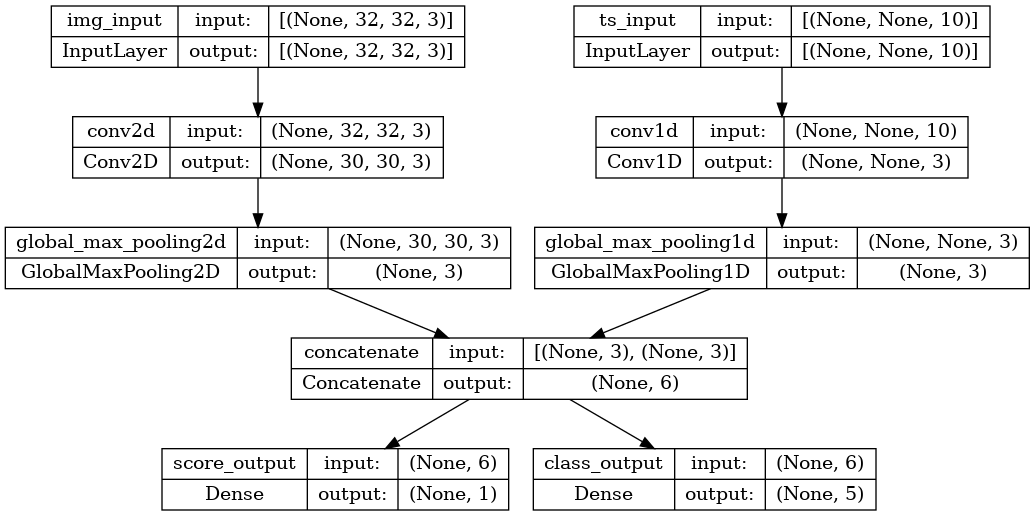

In [29]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

在编译时，通过将损失函数作为列表传递，我们可以为不同的输出指定不同的损失：

In [30]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
)

如果我们仅将单个损失函数传递给模型，则相同的损失函数将应用于每个输出（此处不合适）。

对于指标同样如此：

In [31]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
    metrics=[
        [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        [keras.metrics.CategoricalAccuracy()],
    ],
)

由于我们已为输出层命名，我们还可以通过字典指定每个输出的损失和指标：

In [32]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "score_output": keras.losses.MeanSquaredError(),
        "class_output": keras.losses.CategoricalCrossentropy(),
    },
    metrics={
        "score_output": [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        "class_output": [keras.metrics.CategoricalAccuracy()],
    },
)

如果您的输出超过 2 个，我们建议使用显式名称和字典。

可以使用 `loss_weights` 参数为特定于输出的不同损失赋予不同的权重（例如，在我们的示例中，我们可能希望通过为类损失赋予 2 倍重要性来向“得分”损失赋予特权）：

In [33]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "score_output": keras.losses.MeanSquaredError(),
        "class_output": keras.losses.CategoricalCrossentropy(),
    },
    metrics={
        "score_output": [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        "class_output": [keras.metrics.CategoricalAccuracy()],
    },
    loss_weights={"score_output": 2.0, "class_output": 1.0},
)

如果这些输出用于预测而不是用于训练，也可以选择不计算某些输出的损失：

In [34]:
# List loss version
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[None, keras.losses.CategoricalCrossentropy()],
)

# Or dict loss version
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={"class_output": keras.losses.CategoricalCrossentropy()},
)

将数据传递给 `fit()` 中的多输入或多输出模型的工作方式与在编译中指定损失函数的方式类似：您可以传递 **NumPy 数组的列表**（1:1 映射到接收损失函数的输出），或者**通过字典将输出名称映射到 NumPy 数组**。

In [35]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
)

# Generate dummy NumPy data
img_data = np.random.random_sample(size=(100, 32, 32, 3))
ts_data = np.random.random_sample(size=(100, 20, 10))
score_targets = np.random.random_sample(size=(100, 1))
class_targets = np.random.random_sample(size=(100, 5))

# Fit on lists
model.fit([img_data, ts_data], [score_targets, class_targets], batch_size=32, epochs=1)

# Alternatively, fit on dicts
model.fit(
    {"img_input": img_data, "ts_input": ts_data},
    {"score_output": score_targets, "class_output": class_targets},
    batch_size=32,
    epochs=1,
)

1/4 [======>.......................] - ETA: 6s - loss: 24.8114 - score_output_loss: 1.7848 - class_output_loss: 23.0266

4/4 [==============================] - 2s 9ms/step - loss: 24.9612 - score_output_loss: 1.4938 - class_output_loss: 23.4674


1/4 [======>.......................] - ETA: 1s - loss: 24.8303 - score_output_loss: 1.0725 - class_output_loss: 23.7579

4/4 [==============================] - 0s 5ms/step - loss: 24.4466 - score_output_loss: 0.8520 - class_output_loss: 23.5946


下面是 `Dataset` 的用例：与我们对 NumPy 数组执行的操作类似，`Dataset` 应返回一个字典元组。

In [36]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {"img_input": img_data, "ts_input": ts_data},
        {"score_output": score_targets, "class_output": class_targets},
    )
)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

model.fit(train_dataset, epochs=1)

1/2 [==============>...............] - ETA: 0s - loss: 25.0784 - score_output_loss: 0.6628 - class_output_loss: 24.4156

2/2 [==============================] - 0s 19ms/step - loss: 24.1749 - score_output_loss: 0.6283 - class_output_loss: 23.5465


## 使用回调

Keras 中的回调是在训练过程中的不同时间点（在某个周期开始时、在批次结束时、在某个周期结束时等）调用的对象。它们可用于实现特定行为，例如：

- 在训练期间的不同时间点进行验证（除了内置的按周期验证外）
- 定期或在超过一定准确率阈值时为模型设置检查点
- 当训练似乎停滞不前时，更改模型的学习率
- 当训练似乎停滞不前时，对顶层进行微调
- 在训练结束或超出特定性能阈值时发送电子邮件或即时消息通知
- 等等

回调可以作为列表传递给您对 `fit()` 的调用：

In [37]:
model = get_compiled_model()

callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1,
    )
]
model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=64,
    callbacks=callbacks,
    validation_split=0.2,
)

Epoch 1/20


  1/625 [..............................] - ETA: 7:09 - loss: 2.4003 - sparse_categorical_accuracy: 0.0938

 26/625 [>.............................] - ETA: 1s - loss: 1.5643 - sparse_categorical_accuracy: 0.5751  

 51/625 [=>............................] - ETA: 1s - loss: 1.1758 - sparse_categorical_accuracy: 0.6936

 77/625 [==>...........................] - ETA: 1s - loss: 0.9790 - sparse_categorical_accuracy: 0.7429

102/625 [===>..........................] - ETA: 1s - loss: 0.8488 - sparse_categorical_accuracy: 0.7756

128/625 [=====>........................] - ETA: 0s - loss: 0.7605 - sparse_categorical_accuracy: 0.7977

153/625 [======>.......................] - ETA: 0s - loss: 0.7015 - sparse_categorical_accuracy: 0.8123

178/625 [=======>......................] - ETA: 0s - loss: 0.6520 - sparse_categorical_accuracy: 0.8238

203/625 [========>.....................] - ETA: 0s - loss: 0.6189 - sparse_categorical_accuracy: 0.8313

229/625 [=========>....................] - ETA: 0s - loss: 0.5895 - sparse_categorical_accuracy: 0.8389

254/625 [===========>..................] - ETA: 0s - loss: 0.5653 - sparse_categorical_accuracy: 0.8458

280/625 [============>.................] - ETA: 0s - loss: 0.5397 - sparse_categorical_accuracy: 0.8525

305/625 [=============>................] - ETA: 0s - loss: 0.5203 - sparse_categorical_accuracy: 0.8581

330/625 [==============>...............] - ETA: 0s - loss: 0.5014 - sparse_categorical_accuracy: 0.8631

356/625 [================>.............] - ETA: 0s - loss: 0.4846 - sparse_categorical_accuracy: 0.8670

381/625 [=================>............] - ETA: 0s - loss: 0.4705 - sparse_categorical_accuracy: 0.8703

407/625 [==================>...........] - ETA: 0s - loss: 0.4584 - sparse_categorical_accuracy: 0.8738

433/625 [===================>..........] - ETA: 0s - loss: 0.4450 - sparse_categorical_accuracy: 0.8769

459/625 [=====================>........] - ETA: 0s - loss: 0.4357 - sparse_categorical_accuracy: 0.8792

484/625 [======================>.......] - ETA: 0s - loss: 0.4254 - sparse_categorical_accuracy: 0.8821

510/625 [=======================>......] - ETA: 0s - loss: 0.4149 - sparse_categorical_accuracy: 0.8846

536/625 [========================>.....] - ETA: 0s - loss: 0.4048 - sparse_categorical_accuracy: 0.8870

562/625 [=========================>....] - ETA: 0s - loss: 0.3983 - sparse_categorical_accuracy: 0.8885

588/625 [===========================>..] - ETA: 0s - loss: 0.3905 - sparse_categorical_accuracy: 0.8907

614/625 [============================>.] - ETA: 0s - loss: 0.3827 - sparse_categorical_accuracy: 0.8929

625/625 [==============================] - 3s 3ms/step - loss: 0.3797 - sparse_categorical_accuracy: 0.8938 - val_loss: 0.2467 - val_sparse_categorical_accuracy: 0.9229


Epoch 2/20


  1/625 [..............................] - ETA: 1s - loss: 0.2098 - sparse_categorical_accuracy: 0.9375

 26/625 [>.............................] - ETA: 1s - loss: 0.1932 - sparse_categorical_accuracy: 0.9465

 52/625 [=>............................] - ETA: 1s - loss: 0.1988 - sparse_categorical_accuracy: 0.9441

 78/625 [==>...........................] - ETA: 1s - loss: 0.1968 - sparse_categorical_accuracy: 0.9433

103/625 [===>..........................] - ETA: 1s - loss: 0.2002 - sparse_categorical_accuracy: 0.9427

129/625 [=====>........................] - ETA: 0s - loss: 0.2010 - sparse_categorical_accuracy: 0.9421

155/625 [======>.......................] - ETA: 0s - loss: 0.2036 - sparse_categorical_accuracy: 0.9410

180/625 [=======>......................] - ETA: 0s - loss: 0.1995 - sparse_categorical_accuracy: 0.9419

205/625 [========>.....................] - ETA: 0s - loss: 0.1967 - sparse_categorical_accuracy: 0.9431

230/625 [==========>...................] - ETA: 0s - loss: 0.1950 - sparse_categorical_accuracy: 0.9433

255/625 [===========>..................] - ETA: 0s - loss: 0.1929 - sparse_categorical_accuracy: 0.9433

280/625 [============>.................] - ETA: 0s - loss: 0.1915 - sparse_categorical_accuracy: 0.9431

305/625 [=============>................] - ETA: 0s - loss: 0.1894 - sparse_categorical_accuracy: 0.9441

330/625 [==============>...............] - ETA: 0s - loss: 0.1867 - sparse_categorical_accuracy: 0.9450

356/625 [================>.............] - ETA: 0s - loss: 0.1861 - sparse_categorical_accuracy: 0.9453

381/625 [=================>............] - ETA: 0s - loss: 0.1855 - sparse_categorical_accuracy: 0.9450

407/625 [==================>...........] - ETA: 0s - loss: 0.1821 - sparse_categorical_accuracy: 0.9460

432/625 [===================>..........] - ETA: 0s - loss: 0.1807 - sparse_categorical_accuracy: 0.9465

458/625 [====================>.........] - ETA: 0s - loss: 0.1804 - sparse_categorical_accuracy: 0.9469

483/625 [======================>.......] - ETA: 0s - loss: 0.1797 - sparse_categorical_accuracy: 0.9471

509/625 [=======================>......] - ETA: 0s - loss: 0.1780 - sparse_categorical_accuracy: 0.9477

535/625 [========================>.....] - ETA: 0s - loss: 0.1759 - sparse_categorical_accuracy: 0.9482

560/625 [=========================>....] - ETA: 0s - loss: 0.1749 - sparse_categorical_accuracy: 0.9484

586/625 [===========================>..] - ETA: 0s - loss: 0.1738 - sparse_categorical_accuracy: 0.9488

611/625 [============================>.] - ETA: 0s - loss: 0.1724 - sparse_categorical_accuracy: 0.9492

625/625 [==============================] - 2s 2ms/step - loss: 0.1722 - sparse_categorical_accuracy: 0.9494 - val_loss: 0.1697 - val_sparse_categorical_accuracy: 0.9493


Epoch 3/20


  1/625 [..............................] - ETA: 1s - loss: 0.1174 - sparse_categorical_accuracy: 0.9688

 26/625 [>.............................] - ETA: 1s - loss: 0.1326 - sparse_categorical_accuracy: 0.9621

 52/625 [=>............................] - ETA: 1s - loss: 0.1285 - sparse_categorical_accuracy: 0.9606

 78/625 [==>...........................] - ETA: 1s - loss: 0.1347 - sparse_categorical_accuracy: 0.9593

104/625 [===>..........................] - ETA: 1s - loss: 0.1283 - sparse_categorical_accuracy: 0.9618

129/625 [=====>........................] - ETA: 0s - loss: 0.1257 - sparse_categorical_accuracy: 0.9627

154/625 [======>.......................] - ETA: 0s - loss: 0.1246 - sparse_categorical_accuracy: 0.9632

179/625 [=======>......................] - ETA: 0s - loss: 0.1238 - sparse_categorical_accuracy: 0.9625

204/625 [========>.....................] - ETA: 0s - loss: 0.1235 - sparse_categorical_accuracy: 0.9619

229/625 [=========>....................] - ETA: 0s - loss: 0.1249 - sparse_categorical_accuracy: 0.9621

254/625 [===========>..................] - ETA: 0s - loss: 0.1268 - sparse_categorical_accuracy: 0.9616

280/625 [============>.................] - ETA: 0s - loss: 0.1292 - sparse_categorical_accuracy: 0.9608

306/625 [=============>................] - ETA: 0s - loss: 0.1280 - sparse_categorical_accuracy: 0.9607

331/625 [==============>...............] - ETA: 0s - loss: 0.1270 - sparse_categorical_accuracy: 0.9614

357/625 [================>.............] - ETA: 0s - loss: 0.1261 - sparse_categorical_accuracy: 0.9620

382/625 [=================>............] - ETA: 0s - loss: 0.1269 - sparse_categorical_accuracy: 0.9621

407/625 [==================>...........] - ETA: 0s - loss: 0.1260 - sparse_categorical_accuracy: 0.9623

432/625 [===================>..........] - ETA: 0s - loss: 0.1255 - sparse_categorical_accuracy: 0.9623

457/625 [====================>.........] - ETA: 0s - loss: 0.1245 - sparse_categorical_accuracy: 0.9624

483/625 [======================>.......] - ETA: 0s - loss: 0.1247 - sparse_categorical_accuracy: 0.9626

508/625 [=======================>......] - ETA: 0s - loss: 0.1237 - sparse_categorical_accuracy: 0.9629

534/625 [========================>.....] - ETA: 0s - loss: 0.1244 - sparse_categorical_accuracy: 0.9628

559/625 [=========================>....] - ETA: 0s - loss: 0.1256 - sparse_categorical_accuracy: 0.9624

584/625 [===========================>..] - ETA: 0s - loss: 0.1252 - sparse_categorical_accuracy: 0.9626

609/625 [============================>.] - ETA: 0s - loss: 0.1260 - sparse_categorical_accuracy: 0.9625

625/625 [==============================] - 2s 2ms/step - loss: 0.1254 - sparse_categorical_accuracy: 0.9625 - val_loss: 0.1457 - val_sparse_categorical_accuracy: 0.9566


Epoch 4/20


  1/625 [..............................] - ETA: 1s - loss: 0.1638 - sparse_categorical_accuracy: 0.9531

 27/625 [>.............................] - ETA: 1s - loss: 0.0932 - sparse_categorical_accuracy: 0.9705

 53/625 [=>............................] - ETA: 1s - loss: 0.0952 - sparse_categorical_accuracy: 0.9708

 80/625 [==>...........................] - ETA: 1s - loss: 0.0961 - sparse_categorical_accuracy: 0.9707

105/625 [====>.........................] - ETA: 1s - loss: 0.0981 - sparse_categorical_accuracy: 0.9696

131/625 [=====>........................] - ETA: 0s - loss: 0.0998 - sparse_categorical_accuracy: 0.9689

156/625 [======>.......................] - ETA: 0s - loss: 0.1014 - sparse_categorical_accuracy: 0.9677

181/625 [=======>......................] - ETA: 0s - loss: 0.1015 - sparse_categorical_accuracy: 0.9681

206/625 [========>.....................] - ETA: 0s - loss: 0.1009 - sparse_categorical_accuracy: 0.9682

232/625 [==========>...................] - ETA: 0s - loss: 0.1010 - sparse_categorical_accuracy: 0.9688

258/625 [===========>..................] - ETA: 0s - loss: 0.1024 - sparse_categorical_accuracy: 0.9685

284/625 [============>.................] - ETA: 0s - loss: 0.1006 - sparse_categorical_accuracy: 0.9690

309/625 [=============>................] - ETA: 0s - loss: 0.0990 - sparse_categorical_accuracy: 0.9697

336/625 [===============>..............] - ETA: 0s - loss: 0.0989 - sparse_categorical_accuracy: 0.9693

362/625 [================>.............] - ETA: 0s - loss: 0.0993 - sparse_categorical_accuracy: 0.9692

386/625 [=================>............] - ETA: 0s - loss: 0.0993 - sparse_categorical_accuracy: 0.9694

410/625 [==================>...........] - ETA: 0s - loss: 0.0986 - sparse_categorical_accuracy: 0.9695

435/625 [===================>..........] - ETA: 0s - loss: 0.0999 - sparse_categorical_accuracy: 0.9691

460/625 [=====================>........] - ETA: 0s - loss: 0.0995 - sparse_categorical_accuracy: 0.9694

486/625 [======================>.......] - ETA: 0s - loss: 0.0990 - sparse_categorical_accuracy: 0.9696

511/625 [=======================>......] - ETA: 0s - loss: 0.0989 - sparse_categorical_accuracy: 0.9695

537/625 [========================>.....] - ETA: 0s - loss: 0.1000 - sparse_categorical_accuracy: 0.9692

562/625 [=========================>....] - ETA: 0s - loss: 0.1004 - sparse_categorical_accuracy: 0.9692

588/625 [===========================>..] - ETA: 0s - loss: 0.1005 - sparse_categorical_accuracy: 0.9693

613/625 [============================>.] - ETA: 0s - loss: 0.1005 - sparse_categorical_accuracy: 0.9693

625/625 [==============================] - 2s 2ms/step - loss: 0.1004 - sparse_categorical_accuracy: 0.9693 - val_loss: 0.1441 - val_sparse_categorical_accuracy: 0.9586


Epoch 5/20


  1/625 [..............................] - ETA: 1s - loss: 0.0856 - sparse_categorical_accuracy: 0.9531

 26/625 [>.............................] - ETA: 1s - loss: 0.0870 - sparse_categorical_accuracy: 0.9700

 52/625 [=>............................] - ETA: 1s - loss: 0.0827 - sparse_categorical_accuracy: 0.9745

 77/625 [==>...........................] - ETA: 1s - loss: 0.0860 - sparse_categorical_accuracy: 0.9750

103/625 [===>..........................] - ETA: 1s - loss: 0.0849 - sparse_categorical_accuracy: 0.9756

129/625 [=====>........................] - ETA: 0s - loss: 0.0828 - sparse_categorical_accuracy: 0.9753

154/625 [======>.......................] - ETA: 0s - loss: 0.0822 - sparse_categorical_accuracy: 0.9754

181/625 [=======>......................] - ETA: 0s - loss: 0.0838 - sparse_categorical_accuracy: 0.9750

206/625 [========>.....................] - ETA: 0s - loss: 0.0820 - sparse_categorical_accuracy: 0.9755

231/625 [==========>...................] - ETA: 0s - loss: 0.0812 - sparse_categorical_accuracy: 0.9760

257/625 [===========>..................] - ETA: 0s - loss: 0.0824 - sparse_categorical_accuracy: 0.9751

283/625 [============>.................] - ETA: 0s - loss: 0.0822 - sparse_categorical_accuracy: 0.9753

309/625 [=============>................] - ETA: 0s - loss: 0.0811 - sparse_categorical_accuracy: 0.9754

334/625 [===============>..............] - ETA: 0s - loss: 0.0807 - sparse_categorical_accuracy: 0.9751

360/625 [================>.............] - ETA: 0s - loss: 0.0811 - sparse_categorical_accuracy: 0.9750

386/625 [=================>............] - ETA: 0s - loss: 0.0822 - sparse_categorical_accuracy: 0.9747

411/625 [==================>...........] - ETA: 0s - loss: 0.0831 - sparse_categorical_accuracy: 0.9746

437/625 [===================>..........] - ETA: 0s - loss: 0.0833 - sparse_categorical_accuracy: 0.9747

463/625 [=====================>........] - ETA: 0s - loss: 0.0828 - sparse_categorical_accuracy: 0.9748

489/625 [======================>.......] - ETA: 0s - loss: 0.0824 - sparse_categorical_accuracy: 0.9751

514/625 [=======================>......] - ETA: 0s - loss: 0.0830 - sparse_categorical_accuracy: 0.9748

539/625 [========================>.....] - ETA: 0s - loss: 0.0838 - sparse_categorical_accuracy: 0.9747

564/625 [==========================>...] - ETA: 0s - loss: 0.0828 - sparse_categorical_accuracy: 0.9750

590/625 [===========================>..] - ETA: 0s - loss: 0.0834 - sparse_categorical_accuracy: 0.9749

615/625 [============================>.] - ETA: 0s - loss: 0.0839 - sparse_categorical_accuracy: 0.9747

625/625 [==============================] - 2s 2ms/step - loss: 0.0837 - sparse_categorical_accuracy: 0.9748 - val_loss: 0.1432 - val_sparse_categorical_accuracy: 0.9596


Epoch 5: early stopping


### 提供多个内置回调

Keras 中已经提供多个内置回调，例如：

- `ModelCheckpoint`：定期保存模型。
- `EarlyStopping`：当训练不再改善验证指标时，停止训练。
- `TensorBoard`：定期编写可在 [TensorBoard](https://tensorflow.google.cn/tensorboard) 中可视化的模型日志（更多详细信息，请参阅“可视化”部分）。
- `CSVLogger`：将损失和指标数据流式传输到 CSV 文件。
- 等等

有关完整列表，请参阅[回调文档](https://tensorflow.google.cn/api_docs/python/tf/keras/callbacks/)。

### 编写您自己的回调

您可以通过扩展基类 `keras.callbacks.Callback` 来创建自定义回调。回调可以通过类属性 `self.model` 访问其关联的模型。

确保阅读[编写自定义回调的完整指南](https://tensorflow.google.cn/guide/keras/custom_callback/)。

下面是一个简单的示例，在训练期间保存每个批次的损失值列表：

In [38]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []

    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get("loss"))


## 为模型设置检查点

根据相对较大的数据集训练模型时，经常保存模型的检查点至关重要。

实现此目标的最简单方式是使用 `ModelCheckpoint` 回调：

In [39]:
model = get_compiled_model()

callbacks = [
    keras.callbacks.ModelCheckpoint(
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        # The saved model name will include the current epoch.
        filepath="mymodel_{epoch}",
        save_best_only=True,  # Only save a model if `val_loss` has improved.
        monitor="val_loss",
        verbose=1,
    )
]
model.fit(
    x_train, y_train, epochs=2, batch_size=64, callbacks=callbacks, validation_split=0.2
)

Epoch 1/2


  1/625 [..............................] - ETA: 7:04 - loss: 2.3272 - sparse_categorical_accuracy: 0.0625

 26/625 [>.............................] - ETA: 1s - loss: 1.6305 - sparse_categorical_accuracy: 0.5475  

 52/625 [=>............................] - ETA: 1s - loss: 1.2290 - sparse_categorical_accuracy: 0.6752

 77/625 [==>...........................] - ETA: 1s - loss: 1.0138 - sparse_categorical_accuracy: 0.7354

102/625 [===>..........................] - ETA: 1s - loss: 0.8852 - sparse_categorical_accuracy: 0.7690

128/625 [=====>........................] - ETA: 0s - loss: 0.7929 - sparse_categorical_accuracy: 0.7911

153/625 [======>.......................] - ETA: 0s - loss: 0.7329 - sparse_categorical_accuracy: 0.8047

179/625 [=======>......................] - ETA: 0s - loss: 0.6791 - sparse_categorical_accuracy: 0.8181

205/625 [========>.....................] - ETA: 0s - loss: 0.6407 - sparse_categorical_accuracy: 0.8283

231/625 [==========>...................] - ETA: 0s - loss: 0.6054 - sparse_categorical_accuracy: 0.8373

256/625 [===========>..................] - ETA: 0s - loss: 0.5792 - sparse_categorical_accuracy: 0.8434

281/625 [============>.................] - ETA: 0s - loss: 0.5584 - sparse_categorical_accuracy: 0.8487

306/625 [=============>................] - ETA: 0s - loss: 0.5359 - sparse_categorical_accuracy: 0.8540

331/625 [==============>...............] - ETA: 0s - loss: 0.5215 - sparse_categorical_accuracy: 0.8568

357/625 [================>.............] - ETA: 0s - loss: 0.5058 - sparse_categorical_accuracy: 0.8610

382/625 [=================>............] - ETA: 0s - loss: 0.4923 - sparse_categorical_accuracy: 0.8640

407/625 [==================>...........] - ETA: 0s - loss: 0.4777 - sparse_categorical_accuracy: 0.8676

432/625 [===================>..........] - ETA: 0s - loss: 0.4659 - sparse_categorical_accuracy: 0.8707

457/625 [====================>.........] - ETA: 0s - loss: 0.4550 - sparse_categorical_accuracy: 0.8732

482/625 [======================>.......] - ETA: 0s - loss: 0.4435 - sparse_categorical_accuracy: 0.8762

507/625 [=======================>......] - ETA: 0s - loss: 0.4331 - sparse_categorical_accuracy: 0.8791

532/625 [========================>.....] - ETA: 0s - loss: 0.4251 - sparse_categorical_accuracy: 0.8810

557/625 [=========================>....] - ETA: 0s - loss: 0.4168 - sparse_categorical_accuracy: 0.8832

583/625 [==========================>...] - ETA: 0s - loss: 0.4086 - sparse_categorical_accuracy: 0.8852

608/625 [============================>.] - ETA: 0s - loss: 0.4014 - sparse_categorical_accuracy: 0.8871


Epoch 1: val_loss improved from inf to 0.25889, saving model to mymodel_1


INFO:tensorflow:Assets written to: mymodel_1/assets


625/625 [==============================] - 3s 4ms/step - loss: 0.3973 - sparse_categorical_accuracy: 0.8883 - val_loss: 0.2589 - val_sparse_categorical_accuracy: 0.9210


Epoch 2/2


  1/625 [..............................] - ETA: 1s - loss: 0.1705 - sparse_categorical_accuracy: 0.9688

 26/625 [>.............................] - ETA: 1s - loss: 0.1858 - sparse_categorical_accuracy: 0.9429

 52/625 [=>............................] - ETA: 1s - loss: 0.2013 - sparse_categorical_accuracy: 0.9405

 78/625 [==>...........................] - ETA: 1s - loss: 0.2067 - sparse_categorical_accuracy: 0.9411

104/625 [===>..........................] - ETA: 1s - loss: 0.2034 - sparse_categorical_accuracy: 0.9422

130/625 [=====>........................] - ETA: 0s - loss: 0.2085 - sparse_categorical_accuracy: 0.9415

156/625 [======>.......................] - ETA: 0s - loss: 0.2079 - sparse_categorical_accuracy: 0.9407

182/625 [=======>......................] - ETA: 0s - loss: 0.2039 - sparse_categorical_accuracy: 0.9410

207/625 [========>.....................] - ETA: 0s - loss: 0.2034 - sparse_categorical_accuracy: 0.9418

233/625 [==========>...................] - ETA: 0s - loss: 0.1988 - sparse_categorical_accuracy: 0.9428

259/625 [===========>..................] - ETA: 0s - loss: 0.1968 - sparse_categorical_accuracy: 0.9432

284/625 [============>.................] - ETA: 0s - loss: 0.1921 - sparse_categorical_accuracy: 0.9438

310/625 [=============>................] - ETA: 0s - loss: 0.1911 - sparse_categorical_accuracy: 0.9440

335/625 [===============>..............] - ETA: 0s - loss: 0.1895 - sparse_categorical_accuracy: 0.9446

360/625 [================>.............] - ETA: 0s - loss: 0.1910 - sparse_categorical_accuracy: 0.9436

385/625 [=================>............] - ETA: 0s - loss: 0.1907 - sparse_categorical_accuracy: 0.9436

410/625 [==================>...........] - ETA: 0s - loss: 0.1895 - sparse_categorical_accuracy: 0.9442

436/625 [===================>..........] - ETA: 0s - loss: 0.1876 - sparse_categorical_accuracy: 0.9449

461/625 [=====================>........] - ETA: 0s - loss: 0.1864 - sparse_categorical_accuracy: 0.9451

486/625 [======================>.......] - ETA: 0s - loss: 0.1867 - sparse_categorical_accuracy: 0.9452

511/625 [=======================>......] - ETA: 0s - loss: 0.1852 - sparse_categorical_accuracy: 0.9456

536/625 [========================>.....] - ETA: 0s - loss: 0.1845 - sparse_categorical_accuracy: 0.9461

561/625 [=========================>....] - ETA: 0s - loss: 0.1830 - sparse_categorical_accuracy: 0.9464

586/625 [===========================>..] - ETA: 0s - loss: 0.1816 - sparse_categorical_accuracy: 0.9467

612/625 [============================>.] - ETA: 0s - loss: 0.1813 - sparse_categorical_accuracy: 0.9466


Epoch 2: val_loss improved from 0.25889 to 0.18413, saving model to mymodel_2


INFO:tensorflow:Assets written to: mymodel_2/assets


625/625 [==============================] - 2s 3ms/step - loss: 0.1818 - sparse_categorical_accuracy: 0.9465 - val_loss: 0.1841 - val_sparse_categorical_accuracy: 0.9438


`ModelCheckpoint` 回调可用于实现容错：在训练随机中断的情况下，从模型的最后保存状态重新开始训练的能力。下面是一个基本示例：

In [40]:
import os

# Prepare a directory to store all the checkpoints.
checkpoint_dir = "./ckpt"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)


def make_or_restore_model():
    # Either restore the latest model, or create a fresh one
    # if there is no checkpoint available.
    checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=os.path.getctime)
        print("Restoring from", latest_checkpoint)
        return keras.models.load_model(latest_checkpoint)
    print("Creating a new model")
    return get_compiled_model()


model = make_or_restore_model()
callbacks = [
    # This callback saves a SavedModel every 100 batches.
    # We include the training loss in the saved model name.
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_dir + "/ckpt-loss={loss:.2f}", save_freq=100
    )
]
model.fit(x_train, y_train, epochs=1, callbacks=callbacks)

Creating a new model


   1/1563 [..............................] - ETA: 17:57 - loss: 2.3354 - sparse_categorical_accuracy: 0.0312

  25/1563 [..............................] - ETA: 3s - loss: 1.7248 - sparse_categorical_accuracy: 0.4875   

  50/1563 [..............................] - ETA: 3s - loss: 1.3413 - sparse_categorical_accuracy: 0.6162

  74/1563 [>.............................] - ETA: 3s - loss: 1.1231 - sparse_categorical_accuracy: 0.6799

  99/1563 [>.............................] - ETA: 3s - loss: 0.9649 - sparse_categorical_accuracy: 0.7263

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.96/assets


 100/1563 [>.............................] - ETA: 9s - loss: 0.9625 - sparse_categorical_accuracy: 0.7275

 125/1563 [=>............................] - ETA: 8s - loss: 0.8615 - sparse_categorical_accuracy: 0.7548

 151/1563 [=>............................] - ETA: 7s - loss: 0.7988 - sparse_categorical_accuracy: 0.7726

 177/1563 [==>...........................] - ETA: 6s - loss: 0.7461 - sparse_categorical_accuracy: 0.7871

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.70/assets


 200/1563 [==>...........................] - ETA: 8s - loss: 0.7042 - sparse_categorical_accuracy: 0.7978

 225/1563 [===>..........................] - ETA: 7s - loss: 0.6681 - sparse_categorical_accuracy: 0.8079

 249/1563 [===>..........................] - ETA: 7s - loss: 0.6410 - sparse_categorical_accuracy: 0.8160

 274/1563 [====>.........................] - ETA: 6s - loss: 0.6139 - sparse_categorical_accuracy: 0.8230

 298/1563 [====>.........................] - ETA: 6s - loss: 0.5935 - sparse_categorical_accuracy: 0.8290

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.59/assets


 300/1563 [====>.........................] - ETA: 7s - loss: 0.5917 - sparse_categorical_accuracy: 0.8296

 323/1563 [=====>........................] - ETA: 7s - loss: 0.5715 - sparse_categorical_accuracy: 0.8348

 348/1563 [=====>........................] - ETA: 6s - loss: 0.5527 - sparse_categorical_accuracy: 0.8406

 373/1563 [======>.......................] - ETA: 6s - loss: 0.5363 - sparse_categorical_accuracy: 0.8453

 397/1563 [======>.......................] - ETA: 6s - loss: 0.5176 - sparse_categorical_accuracy: 0.8503

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.52/assets


 400/1563 [======>.......................] - ETA: 7s - loss: 0.5161 - sparse_categorical_accuracy: 0.8505

 424/1563 [=======>......................] - ETA: 6s - loss: 0.5044 - sparse_categorical_accuracy: 0.8543

 449/1563 [=======>......................] - ETA: 6s - loss: 0.4936 - sparse_categorical_accuracy: 0.8574

 475/1563 [========>.....................] - ETA: 6s - loss: 0.4799 - sparse_categorical_accuracy: 0.8618

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.47/assets


 500/1563 [========>.....................] - ETA: 6s - loss: 0.4707 - sparse_categorical_accuracy: 0.8640

 525/1563 [=========>....................] - ETA: 6s - loss: 0.4649 - sparse_categorical_accuracy: 0.8655

 550/1563 [=========>....................] - ETA: 5s - loss: 0.4555 - sparse_categorical_accuracy: 0.8682

 574/1563 [==========>...................] - ETA: 5s - loss: 0.4468 - sparse_categorical_accuracy: 0.8705

 598/1563 [==========>...................] - ETA: 5s - loss: 0.4409 - sparse_categorical_accuracy: 0.8720

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.44/assets


 600/1563 [==========>...................] - ETA: 6s - loss: 0.4398 - sparse_categorical_accuracy: 0.8724

 623/1563 [==========>...................] - ETA: 5s - loss: 0.4331 - sparse_categorical_accuracy: 0.8742

 647/1563 [===========>..................] - ETA: 5s - loss: 0.4265 - sparse_categorical_accuracy: 0.8762

 671/1563 [===========>..................] - ETA: 5s - loss: 0.4189 - sparse_categorical_accuracy: 0.8785

 695/1563 [============>.................] - ETA: 4s - loss: 0.4125 - sparse_categorical_accuracy: 0.8802

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.41/assets


 700/1563 [============>.................] - ETA: 5s - loss: 0.4110 - sparse_categorical_accuracy: 0.8805

 724/1563 [============>.................] - ETA: 5s - loss: 0.4050 - sparse_categorical_accuracy: 0.8824

 750/1563 [=============>................] - ETA: 5s - loss: 0.3997 - sparse_categorical_accuracy: 0.8841

 775/1563 [=============>................] - ETA: 4s - loss: 0.3948 - sparse_categorical_accuracy: 0.8859

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.39/assets


 800/1563 [==============>...............] - ETA: 5s - loss: 0.3884 - sparse_categorical_accuracy: 0.8877

 822/1563 [==============>...............] - ETA: 4s - loss: 0.3838 - sparse_categorical_accuracy: 0.8890

 845/1563 [===============>..............] - ETA: 4s - loss: 0.3792 - sparse_categorical_accuracy: 0.8902

 868/1563 [===============>..............] - ETA: 4s - loss: 0.3753 - sparse_categorical_accuracy: 0.8912

 892/1563 [================>.............] - ETA: 4s - loss: 0.3716 - sparse_categorical_accuracy: 0.8921

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.37/assets


 900/1563 [================>.............] - ETA: 4s - loss: 0.3709 - sparse_categorical_accuracy: 0.8922

 922/1563 [================>.............] - ETA: 4s - loss: 0.3675 - sparse_categorical_accuracy: 0.8930

 945/1563 [=================>............] - ETA: 3s - loss: 0.3643 - sparse_categorical_accuracy: 0.8939

 968/1563 [=================>............] - ETA: 3s - loss: 0.3616 - sparse_categorical_accuracy: 0.8948

 991/1563 [==================>...........] - ETA: 3s - loss: 0.3574 - sparse_categorical_accuracy: 0.8959

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.36/assets


1000/1563 [==================>...........] - ETA: 3s - loss: 0.3561 - sparse_categorical_accuracy: 0.8963

1024/1563 [==================>...........] - ETA: 3s - loss: 0.3537 - sparse_categorical_accuracy: 0.8967

1048/1563 [===================>..........] - ETA: 3s - loss: 0.3504 - sparse_categorical_accuracy: 0.8977

1071/1563 [===================>..........] - ETA: 3s - loss: 0.3475 - sparse_categorical_accuracy: 0.8987

1094/1563 [===================>..........] - ETA: 2s - loss: 0.3442 - sparse_categorical_accuracy: 0.8995

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.34/assets


1100/1563 [====================>.........] - ETA: 3s - loss: 0.3432 - sparse_categorical_accuracy: 0.8998

1123/1563 [====================>.........] - ETA: 2s - loss: 0.3397 - sparse_categorical_accuracy: 0.9008

1146/1563 [====================>.........] - ETA: 2s - loss: 0.3370 - sparse_categorical_accuracy: 0.9014

1170/1563 [=====================>........] - ETA: 2s - loss: 0.3339 - sparse_categorical_accuracy: 0.9024

1194/1563 [=====================>........] - ETA: 2s - loss: 0.3302 - sparse_categorical_accuracy: 0.9032

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.33/assets


1200/1563 [======================>.......] - ETA: 2s - loss: 0.3296 - sparse_categorical_accuracy: 0.9033

1222/1563 [======================>.......] - ETA: 2s - loss: 0.3269 - sparse_categorical_accuracy: 0.9043

1245/1563 [======================>.......] - ETA: 2s - loss: 0.3251 - sparse_categorical_accuracy: 0.9049

1268/1563 [=======================>......] - ETA: 1s - loss: 0.3219 - sparse_categorical_accuracy: 0.9058

1291/1563 [=======================>......] - ETA: 1s - loss: 0.3192 - sparse_categorical_accuracy: 0.9066

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.32/assets


1300/1563 [=======================>......] - ETA: 1s - loss: 0.3187 - sparse_categorical_accuracy: 0.9067

1324/1563 [========================>.....] - ETA: 1s - loss: 0.3164 - sparse_categorical_accuracy: 0.9073

1349/1563 [========================>.....] - ETA: 1s - loss: 0.3147 - sparse_categorical_accuracy: 0.9078

1374/1563 [=========================>....] - ETA: 1s - loss: 0.3123 - sparse_categorical_accuracy: 0.9085

1399/1563 [=========================>....] - ETA: 1s - loss: 0.3111 - sparse_categorical_accuracy: 0.9088

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.31/assets


1400/1563 [=========================>....] - ETA: 1s - loss: 0.3109 - sparse_categorical_accuracy: 0.9088

1423/1563 [==========================>...] - ETA: 0s - loss: 0.3090 - sparse_categorical_accuracy: 0.9093

1447/1563 [==========================>...] - ETA: 0s - loss: 0.3066 - sparse_categorical_accuracy: 0.9099

1471/1563 [===========================>..] - ETA: 0s - loss: 0.3042 - sparse_categorical_accuracy: 0.9106

1495/1563 [===========================>..] - ETA: 0s - loss: 0.3027 - sparse_categorical_accuracy: 0.9111

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.30/assets


1500/1563 [===========================>..] - ETA: 0s - loss: 0.3027 - sparse_categorical_accuracy: 0.9111

1523/1563 [============================>.] - ETA: 0s - loss: 0.3006 - sparse_categorical_accuracy: 0.9117

1547/1563 [============================>.] - ETA: 0s - loss: 0.2983 - sparse_categorical_accuracy: 0.9123

1563/1563 [==============================] - 11s 6ms/step - loss: 0.2976 - sparse_categorical_accuracy: 0.9125


您还可以编写自己的回调来保存和恢复模型。

有关序列化和保存的完整指南，请参阅[保存和序列化模型](https://tensorflow.google.cn/guide/keras/save_and_serialize/)指南。

## 使用学习率时间表

训练深度学习模型的常见模式是随着训练的进行逐渐减少学习。这通常称为“学习率衰减”。

学习衰减时间表可以是静态的（根据当前周期或当前批次索引预先确定），也可以是动态的（响应模型的当前行为，尤其是验证损失）。

### 将时间表传递给优化器

通过将时间表对象作为优化器中的 `learning_rate` 参数传递，您可以轻松使用静态学习率衰减时间表：

In [41]:
initial_learning_rate = 0.1
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule)

提供了几个内置时间表：`ExponentialDecay`、`PiecewiseConstantDecay`、`PolynomialDecay` 和 `InverseTimeDecay`。

### 使用回调实现动态学习率时间表

由于优化器无法访问验证指标，因此无法使用这些时间表对象来实现动态学习率时间表（例如，当验证损失不再改善时降低学习率）。

但是，回调确实可以访问所有指标，包括验证指标！因此，您可以通过使用可修改优化器上的当前学习率的回调来实现此模式。实际上，它甚至以 `ReduceLROnPlateau` 回调的形式内置。

## 可视化训练期间的损失和指标

在训练期间密切关注模型的最佳方式是使用 [TensorBoard](https://tensorflow.google.cn/tensorboard)，这是一个基于浏览器的应用，它可以在本地运行，为您提供：

- 训练和评估的实时损失和指标图
- （可选）层激活直方图的可视化
- （可选）`Embedding` 层学习的嵌入向量空间的 3D 可视化

如果您已通过 pip 安装了 TensorFlow，则应当能够从命令行启动 TensorBoard：

```
tensorboard --logdir=/full_path_to_your_logs
```

### 使用 TensorBoard 回调

将 TensorBoard 与 Keras 模型和 fit 方法一起使用的最简单方式是 `TensorBoard` 回调。

在最简单的情况下，只需指定您希望回调写入日志的位置即可：

In [42]:
keras.callbacks.TensorBoard(
    log_dir="/full_path_to_your_logs",
    histogram_freq=0,  # How often to log histogram visualizations
    embeddings_freq=0,  # How often to log embedding visualizations
    update_freq="epoch",
)  # How often to write logs (default: once per epoch)

有关更多信息，请参阅 [`TensorBoard` 回调的文档](https://tensorflow.google.cn/api_docs/python/tf/keras/callbacks/tensorboard/)。